In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normaliser
normaliser = load('./normalisers/x_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

In [9]:
# Normalised train chunks
X_train = np.array([train_norm[i : i + backlook].copy() for i in range(len(train) - backlook)])
Y_train = np.array([train_norm[i + backlook].copy() for i in range(len(train) - backlook)])

In [10]:
# Normalised test chunks
X_test = np.array([test_norm[i : i + backlook].copy() for i in range(len(test) - backlook)])
Y_test = np.array([test_norm[i + backlook].copy() for i in range(len(test) - backlook)])

# Model selection

##### Model constructor

In [11]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(y.shape[-1], activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [12]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [13]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [14]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 1s 358us/step - loss: 0.0274 - val_loss: 0.0036
Epoch 2/24
4143/4143 [==============================] - 1s 156us/step - loss: 0.0366 - val_loss: 0.0100
Epoch 3/24
4143/4143 [==============================] - 1s 155us/step - loss: 0.0116 - val_loss: 0.0023
Epoch 4/24
4143/4143 [==============================] - 1s 156us/step - loss: 0.0107 - val_loss: 0.0023
Epoch 5/24
4143/4143 [==============================] - 1s 155us/step - loss: 0.0069 - val_loss: 0.0011
Epoch 6/24
4143/4143 [==============================] - 1s 163us/step - loss: 0.0078 - val_loss: 0.0018
Epoch 7/24
4143/4143 [==============================] - 1s 172us/step - loss: 0.0052 - val_loss: 0.0010
Epoch 8/24
4143/4143 [==============================] - 1s 164us/step - loss: 0.0060 - val

4143/4143 [==============================] - 1s 158us/step - loss: 0.0020 - val_loss: 8.8923e-04
Epoch 24/24
4143/4143 [==============================] - 1s 158us/step - loss: 0.0019 - val_loss: 8.8206e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.1710 - val_loss: 0.1943
Epoch 2/24
4143/4143 [==============================] - 1s 332us/step - loss: 0.1118 - val_loss: 0.1529
Epoch 3/24
4143/4143 [==============================] - 1s 335us/step - loss: 0.0940 - val_loss: 0.1350
Epoch 4/24
4143/4143 [==============================] - 1s 334us/step - loss: 0.0821 - val_loss: 0.1198
Epoch 5/24
4143/4143 [==============================] - 1s 329us/step - loss: 0.0715 - val_loss: 0.1049
Epoch 6/24
4143/4143 [==============================] - 1s 331us/step - loss: 0.0628 - val_loss: 0.0919
Epoch 7/24
4143/4143 [==============================] - 1s 332us/step - loss: 0.0553 - val_loss: 0.0801
Epoch 8/24
4143/414

4143/4143 [==============================] - 1s 338us/step - loss: 0.0104 - val_loss: 0.0048
Epoch 4/24
4143/4143 [==============================] - 1s 338us/step - loss: 0.0050 - val_loss: 0.0046
Epoch 5/24
4143/4143 [==============================] - 1s 333us/step - loss: 0.0034 - val_loss: 0.0019
Epoch 6/24
4143/4143 [==============================] - 1s 338us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 7/24
4143/4143 [==============================] - 1s 339us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/24
4143/4143 [==============================] - 1s 337us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/24
4143/4143 [==============================] - 1s 337us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/24
4143/4143 [==============================] - 1s 336us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/24
4143/4143 [==============================] - 1s 339us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 12/24
4143/4143 [==============================] - 1s 346us/step - 

4143/4143 [==============================] - 2s 541us/step - loss: 0.0544 - val_loss: 0.0340
Epoch 8/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0538 - val_loss: 0.0316
Epoch 9/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0535 - val_loss: 0.0322
Epoch 10/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0534 - val_loss: 0.0325
Epoch 11/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0534 - val_loss: 0.0332
Epoch 12/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0534 - val_loss: 0.0334
Epoch 13/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0534 - val_loss: 0.0335
Epoch 14/24
4143/4143 [==============================] - 2s 555us/step - loss: 0.0534 - val_loss: 0.0328
Epoch 15/24
4143/4143 [==============================] - 2s 564us/step - loss: 0.0534 - val_loss: 0.0320
Epoch 16/24
4143/4143 [==============================] - 2s 546us/ste

Epoch 13/24
4143/4143 [==============================] - 1s 196us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 14/24
4143/4143 [==============================] - 1s 195us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 15/24
4143/4143 [==============================] - 1s 191us/step - loss: 0.0021 - val_loss: 0.0015
Epoch 16/24
4143/4143 [==============================] - 1s 190us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 17/24
4143/4143 [==============================] - 1s 189us/step - loss: 0.0018 - val_loss: 0.0029
Epoch 18/24
4143/4143 [==============================] - 1s 192us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 19/24
4143/4143 [==============================] - 1s 191us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 20/24
4143/4143 [==============================] - 1s 191us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 21/24
4143/4143 [==============================] - 1s 192us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 22/24
4143/4143 [==============================] 

4143/4143 [==============================] - 1s 234us/step - loss: nan - val_loss: nan
Epoch 21/24
4143/4143 [==============================] - 1s 235us/step - loss: nan - val_loss: nan
Epoch 22/24
4143/4143 [==============================] - 1s 237us/step - loss: nan - val_loss: nan
Epoch 23/24
4143/4143 [==============================] - 1s 236us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 1s 236us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.2878 - val_loss: 0.0031
Epoch 2/24
4143/4143 [==============================] - 1s 235us/step - loss: 0.0068 - val_loss: 0.0012
Epoch 3/24
4143/4143 [==============================] - 1s 241us/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/24
4143/4143 [==============================] - 1s 234us/step - loss: 0.0046 - val_loss: 0.0026
Epoch 5/24
4143/4143 [==============================] 

4143/4143 [==============================] - 4s 847us/step - loss: 0.0750 - val_loss: 0.0145
Epoch 2/24
4143/4143 [==============================] - 1s 355us/step - loss: 0.0257 - val_loss: 0.0119
Epoch 3/24
4143/4143 [==============================] - 1s 357us/step - loss: 0.0133 - val_loss: 0.0036
Epoch 4/24
4143/4143 [==============================] - 1s 356us/step - loss: 0.0062 - val_loss: 0.0073
Epoch 5/24
4143/4143 [==============================] - 1s 359us/step - loss: 0.0038 - val_loss: 0.0025
Epoch 6/24
4143/4143 [==============================] - 1s 357us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/24
4143/4143 [==============================] - 1s 359us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/24
4143/4143 [==============================] - 1s 357us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 9/24
4143/4143 [==============================] - 1s 355us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 10/24
4143/4143 [==============================] - 1s 355us/step - lo

4143/4143 [==============================] - 2s 531us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 7/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 8/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 9/24
4143/4143 [==============================] - 2s 531us/step - loss: 0.0030 - val_loss: 0.0013
Epoch 10/24
4143/4143 [==============================] - 2s 522us/step - loss: 0.0028 - val_loss: 0.0013
Epoch 11/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 12/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 13/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 14/24
4143/4143 [==============================] - 2s 519us/step - loss: 0.0024 - val_loss: 0.0015
Epoch 15/24
4143/4143 [==============================] - 2s 526us/step

4143/4143 [==============================] - 2s 592us/step - loss: 0.0031 - val_loss: 0.0013
Epoch 12/24
4143/4143 [==============================] - 2s 596us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 13/24
4143/4143 [==============================] - 2s 593us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 14/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 15/24
4143/4143 [==============================] - 2s 592us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 16/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 17/24
4143/4143 [==============================] - 2s 591us/step - loss: 0.0021 - val_loss: 0.0030
Epoch 18/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 19/24
4143/4143 [==============================] - 2s 592us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 20/24
4143/4143 [==============================] - 2s 596us/s

Epoch 16/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 17/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 18/24
4143/4143 [==============================] - 2s 535us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 19/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 20/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 21/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 23/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 24/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0015 - val_loss: 0.0012
Train on 4143 samples, validate on 461 samples
Epoch 1/

Epoch 21/24
4143/4143 [==============================] - 1s 338us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 22/24
4143/4143 [==============================] - 1s 344us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 23/24
4143/4143 [==============================] - 1s 337us/step - loss: 0.0026 - val_loss: 0.0016
Epoch 24/24
4143/4143 [==============================] - 1s 340us/step - loss: 0.0025 - val_loss: 0.0015
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 5s 1ms/step - loss: nan - val_loss: nan
Epoch 2/24
4143/4143 [==============================] - 1s 336us/step - loss: nan - val_loss: nan
Epoch 3/24
4143/4143 [==============================] - 1s 336us/step - loss: nan - val_loss: nan
Epoch 4/24
4143/4143 [==============================] - 1s 339us/step - loss: nan - val_loss: nan
Epoch 5/24
4143/4143 [==============================] - 1s 341us/step - loss: nan - val_loss: nan
Epoch 6/24
4143/4143 [=======================

4143/4143 [==============================] - 1s 355us/step - loss: nan - val_loss: nan
Epoch 7/24
4143/4143 [==============================] - 1s 360us/step - loss: nan - val_loss: nan
Epoch 8/24
4143/4143 [==============================] - 1s 354us/step - loss: nan - val_loss: nan
Epoch 9/24
4143/4143 [==============================] - 1s 358us/step - loss: nan - val_loss: nan
Epoch 10/24
4143/4143 [==============================] - 1s 359us/step - loss: nan - val_loss: nan
Epoch 11/24
4143/4143 [==============================] - 1s 359us/step - loss: nan - val_loss: nan
Epoch 12/24
4143/4143 [==============================] - 1s 355us/step - loss: nan - val_loss: nan
Epoch 13/24
4143/4143 [==============================] - 1s 360us/step - loss: nan - val_loss: nan
Epoch 14/24
4143/4143 [==============================] - 1s 358us/step - loss: nan - val_loss: nan
Epoch 15/24
4143/4143 [==============================] - 1s 354us/step - loss: nan - val_loss: nan
Epoch 16/24
4143/4143 [==

4143/4143 [==============================] - 2s 543us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 14/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 15/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 16/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 17/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 18/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 19/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 20/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 21/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 22/24
4143/4143 [==============================] - 2s 540us/s

4143/4143 [==============================] - 2s 517us/step - loss: nan - val_loss: nan
Epoch 20/24
4143/4143 [==============================] - 2s 515us/step - loss: nan - val_loss: nan
Epoch 21/24
4143/4143 [==============================] - 2s 521us/step - loss: nan - val_loss: nan
Epoch 22/24
4143/4143 [==============================] - 2s 516us/step - loss: nan - val_loss: nan
Epoch 23/24
4143/4143 [==============================] - 2s 515us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 2s 522us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 7s 2ms/step - loss: nan - val_loss: nan
Epoch 2/24
4143/4143 [==============================] - 2s 516us/step - loss: nan - val_loss: nan
Epoch 3/24
4143/4143 [==============================] - 2s 519us/step - loss: nan - val_loss: nan
Epoch 4/24
4143/4143 [==============================] - 2s 513us/step - loss: n

Epoch 3/24
4143/4143 [==============================] - 2s 523us/step - loss: 0.0062 - val_loss: 0.0023
Epoch 4/24
4143/4143 [==============================] - 2s 522us/step - loss: 0.0044 - val_loss: 0.0022
Epoch 5/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 6/24
4143/4143 [==============================] - 2s 525us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/24
4143/4143 [==============================] - 2s 523us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 8/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 9/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/24
4143/4143 [==============================] - 2s 517us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 11/24
4143/4143 [==============================] - 2s 529us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 12/24
4143/4143 [==============================] - 2s 52

Epoch 8/24
4143/4143 [==============================] - 2s 366us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/24
4143/4143 [==============================] - 2s 363us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 10/24
4143/4143 [==============================] - 2s 375us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/24
4143/4143 [==============================] - 2s 364us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 12/24
4143/4143 [==============================] - 2s 364us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 13/24
4143/4143 [==============================] - 1s 361us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 14/24
4143/4143 [==============================] - 2s 362us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 15/24
4143/4143 [==============================] - 1s 360us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 16/24
4143/4143 [==============================] - 2s 365us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 17/24
4143/4143 [==============================] - 

4143/4143 [==============================] - 2s 598us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 14/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 15/24
4143/4143 [==============================] - 2s 601us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 16/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 17/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0015 - val_loss: 9.7732e-04
Epoch 18/24
4143/4143 [==============================] - 2s 593us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 19/24
4143/4143 [==============================] - 2s 592us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 20/24
4143/4143 [==============================] - 2s 592us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0014 - val_loss: 9.7810e-04
Epoch 22/24
4143/4143 [==============================] - 2s

4143/4143 [==============================] - 3s 619us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 20/24
4143/4143 [==============================] - 3s 620us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 21/24
4143/4143 [==============================] - 3s 623us/step - loss: 0.0026 - val_loss: 0.0063
Epoch 22/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 23/24
4143/4143 [==============================] - 3s 622us/step - loss: 0.0031 - val_loss: 0.0063
Epoch 24/24
4143/4143 [==============================] - 3s 622us/step - loss: 0.0031 - val_loss: 0.0012

GENERATION 6

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 9s 2ms/step - loss: 0.2679 - val_loss: 0.1332
Epoch 2/24
4143/4143 [==============================] - 2s 456us/step - loss: 0.0701 - val_loss: 0.0370
Epoch 3/24
4143/4143 [==============================] - 2s 457us/step - loss: 0.0217 - val_loss: 0.0230
Epoch 4/24

Epoch 24/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0015 - val_loss: 0.0018
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 9s 2ms/step - loss: 0.1597 - val_loss: 0.0582
Epoch 2/24
4143/4143 [==============================] - 2s 443us/step - loss: 0.0351 - val_loss: 0.0073
Epoch 3/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0192 - val_loss: 0.0213
Epoch 4/24
4143/4143 [==============================] - 2s 442us/step - loss: 0.0165 - val_loss: 0.0063
Epoch 5/24
4143/4143 [==============================] - 2s 444us/step - loss: 0.0106 - val_loss: 0.0161
Epoch 6/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0107 - val_loss: 0.0064
Epoch 7/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0055 - val_loss: 0.0034
Epoch 8/24
4143/4143 [==============================] - 2s 446us/step - loss: 0.0071 - val_loss: 0.0062
Epoch 9/24
4143/41

4143/4143 [==============================] - 2s 416us/step - loss: 0.0055 - val_loss: 0.0101
Epoch 5/24
4143/4143 [==============================] - 2s 415us/step - loss: 0.0053 - val_loss: 0.0049
Epoch 6/24
4143/4143 [==============================] - 2s 417us/step - loss: 0.0045 - val_loss: 0.0058
Epoch 7/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0049 - val_loss: 0.0046
Epoch 8/24
4143/4143 [==============================] - 2s 417us/step - loss: 0.0037 - val_loss: 0.0085
Epoch 9/24
4143/4143 [==============================] - 2s 418us/step - loss: 0.0051 - val_loss: 0.0023
Epoch 10/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0033 - val_loss: 0.0060
Epoch 11/24
4143/4143 [==============================] - 2s 418us/step - loss: 0.0043 - val_loss: 0.0040
Epoch 12/24
4143/4143 [==============================] - 2s 420us/step - loss: 0.0036 - val_loss: 0.0013
Epoch 13/24
4143/4143 [==============================] - 2s 415us/step -

Epoch 9/24
4143/4143 [==============================] - 2s 424us/step - loss: 0.0235 - val_loss: 0.0124
Epoch 10/24
4143/4143 [==============================] - 2s 427us/step - loss: 0.0217 - val_loss: 0.0116
Epoch 11/24
4143/4143 [==============================] - 2s 421us/step - loss: 0.0202 - val_loss: 0.0107
Epoch 12/24
4143/4143 [==============================] - 2s 405us/step - loss: 0.0187 - val_loss: 0.0090
Epoch 13/24
4143/4143 [==============================] - 2s 414us/step - loss: 0.0173 - val_loss: 0.0084
Epoch 14/24
4143/4143 [==============================] - 2s 417us/step - loss: 0.0161 - val_loss: 0.0075
Epoch 15/24
4143/4143 [==============================] - 2s 411us/step - loss: 0.0151 - val_loss: 0.0068
Epoch 16/24
4143/4143 [==============================] - 2s 411us/step - loss: 0.0142 - val_loss: 0.0059
Epoch 17/24
4143/4143 [==============================] - 2s 408us/step - loss: 0.0132 - val_loss: 0.0055
Epoch 18/24
4143/4143 [==============================] -

Epoch 14/24
4143/4143 [==============================] - 3s 629us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 15/24
4143/4143 [==============================] - 3s 634us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 16/24
4143/4143 [==============================] - 3s 633us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 17/24
4143/4143 [==============================] - 3s 634us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 18/24
4143/4143 [==============================] - 3s 633us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 19/24
4143/4143 [==============================] - 3s 635us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 20/24
4143/4143 [==============================] - 3s 644us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 21/24
4143/4143 [==============================] - 3s 639us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] - 3s 632us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 23/24
4143/4143 [==============================] 

Epoch 19/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 20/24
4143/4143 [==============================] - 2s 525us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 21/24
4143/4143 [==============================] - 2s 517us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 22/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 23/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 24/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0018 - val_loss: 0.0013
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0737 - val_loss: 0.0088
Epoch 2/24
4143/4143 [==============================] - 2s 519us/step - loss: 0.0190 - val_loss: 0.0044
Epoch 3/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0078 - val_loss: 0.0064
Epoch 4/24
4

Epoch 24/24
4143/4143 [==============================] - 3s 639us/step - loss: 0.0038 - val_loss: 0.0079
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 14s 3ms/step - loss: 0.0691 - val_loss: 0.0214
Epoch 2/24
4143/4143 [==============================] - 3s 614us/step - loss: 0.0270 - val_loss: 0.0156
Epoch 3/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0134 - val_loss: 0.0056
Epoch 4/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0070 - val_loss: 0.0024
Epoch 5/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0041 - val_loss: 0.0023
Epoch 6/24
4143/4143 [==============================] - 3s 611us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 7/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/24
4143/4143 [==============================] - 3s 612us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/24
4143/4

4143/4143 [==============================] - 3s 615us/step - loss: 0.1449 - val_loss: 0.0793
Epoch 5/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0979 - val_loss: 0.0512
Epoch 6/24
4143/4143 [==============================] - 3s 618us/step - loss: 0.0716 - val_loss: 0.0355
Epoch 7/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0535 - val_loss: 0.0162
Epoch 8/24
4143/4143 [==============================] - 3s 614us/step - loss: 0.0394 - val_loss: 0.0096
Epoch 9/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0298 - val_loss: 0.0061
Epoch 10/24
4143/4143 [==============================] - 3s 625us/step - loss: 0.0236 - val_loss: 0.0041
Epoch 11/24
4143/4143 [==============================] - 3s 620us/step - loss: 0.0200 - val_loss: 0.0039
Epoch 12/24
4143/4143 [==============================] - 3s 622us/step - loss: 0.0181 - val_loss: 0.0074
Epoch 13/24
4143/4143 [==============================] - 3s 621us/step -

4143/4143 [==============================] - 2s 475us/step - loss: 0.0070 - val_loss: 0.0075
Epoch 10/24
4143/4143 [==============================] - 2s 470us/step - loss: 0.0085 - val_loss: 0.0041
Epoch 11/24
4143/4143 [==============================] - 2s 468us/step - loss: 0.0046 - val_loss: 0.0032
Epoch 12/24
4143/4143 [==============================] - 2s 471us/step - loss: 0.0046 - val_loss: 0.0118
Epoch 13/24
4143/4143 [==============================] - 2s 469us/step - loss: 0.0114 - val_loss: 0.0042
Epoch 14/24
4143/4143 [==============================] - 2s 468us/step - loss: 0.0057 - val_loss: 0.0057
Epoch 15/24
4143/4143 [==============================] - 2s 466us/step - loss: 0.0040 - val_loss: 0.0033
Epoch 16/24
4143/4143 [==============================] - 2s 473us/step - loss: 0.0034 - val_loss: 0.0021
Epoch 17/24
4143/4143 [==============================] - 2s 471us/step - loss: 0.0030 - val_loss: 0.0045
Epoch 18/24
4143/4143 [==============================] - 2s 469us/s

Epoch 14/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 15/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 16/24
4143/4143 [==============================] - 2s 567us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 17/24
4143/4143 [==============================] - 2s 571us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 18/24
4143/4143 [==============================] - 2s 564us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 19/24
4143/4143 [==============================] - 2s 566us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 20/24
4143/4143 [==============================] - 2s 574us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 565us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] - 2s 570us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 23/24
4143/4143 [==============================] 

Epoch 19/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0045 - val_loss: 0.0019
Epoch 20/24
4143/4143 [==============================] - 3s 623us/step - loss: 0.0049 - val_loss: 0.0061
Epoch 21/24
4143/4143 [==============================] - 3s 626us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 22/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0046 - val_loss: 0.0071
Epoch 23/24
4143/4143 [==============================] - 3s 624us/step - loss: 0.0033 - val_loss: 0.0018
Epoch 24/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0044 - val_loss: 0.0125
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 17s 4ms/step - loss: 0.0895 - val_loss: 0.0450
Epoch 2/24
4143/4143 [==============================] - 3s 623us/step - loss: 0.0367 - val_loss: 0.0247
Epoch 3/24
4143/4143 [==============================] - 3s 626us/step - loss: 0.0237 - val_loss: 0.0107
Epoch 4/24
4

Epoch 24/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0093 - val_loss: 0.0282
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 19s 4ms/step - loss: 1.2824 - val_loss: 0.0212
Epoch 2/24
4143/4143 [==============================] - 3s 633us/step - loss: 0.0394 - val_loss: 0.0159
Epoch 3/24
4143/4143 [==============================] - 3s 618us/step - loss: 0.0217 - val_loss: 0.0363
Epoch 4/24
4143/4143 [==============================] - 3s 632us/step - loss: 0.0348 - val_loss: 0.0759
Epoch 5/24
4143/4143 [==============================] - 3s 620us/step - loss: 0.0291 - val_loss: 0.0189
Epoch 6/24
4143/4143 [==============================] - 3s 632us/step - loss: 0.0280 - val_loss: 0.0117
Epoch 7/24
4143/4143 [==============================] - 3s 631us/step - loss: 0.0222 - val_loss: 0.0723
Epoch 8/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0640 - val_loss: 0.0021
Epoch 9/24
4143/4

4143/4143 [==============================] - 3s 620us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/24
4143/4143 [==============================] - 3s 627us/step - loss: 0.0024 - val_loss: 0.0016
Epoch 6/24
4143/4143 [==============================] - 2s 575us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 7/24
4143/4143 [==============================] - 2s 566us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 8/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 9/24
4143/4143 [==============================] - 2s 572us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/24
4143/4143 [==============================] - 2s 571us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/24
4143/4143 [==============================] - 2s 567us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 12/24
4143/4143 [==============================] - 2s 572us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 13/24
4143/4143 [==============================] - 2s 568us/step -

4143/4143 [==============================] - 2s 502us/step - loss: 0.0079 - val_loss: 0.0168
Epoch 10/24
4143/4143 [==============================] - 2s 507us/step - loss: 0.0057 - val_loss: 0.0033
Epoch 11/24
4143/4143 [==============================] - 2s 502us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 12/24
4143/4143 [==============================] - 2s 501us/step - loss: 0.0033 - val_loss: 0.0019
Epoch 13/24
4143/4143 [==============================] - 2s 506us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 14/24
4143/4143 [==============================] - 2s 499us/step - loss: 0.0048 - val_loss: 0.0147
Epoch 15/24
4143/4143 [==============================] - 2s 506us/step - loss: 0.0063 - val_loss: 0.0059
Epoch 16/24
4143/4143 [==============================] - 2s 506us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 17/24
4143/4143 [==============================] - 2s 501us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 18/24
4143/4143 [==============================] - 2s 507us/s

4143/4143 [==============================] - 2s 539us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 15/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0021 - val_loss: 0.0045
Epoch 16/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0024 - val_loss: 0.0016
Epoch 17/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 18/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 19/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 20/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0022 - val_loss: 0.0045
Epoch 21/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 22/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0021 - val_loss: 0.0036
Epoch 23/24
4143/4143 [==============================] - 2s 543us/s

Epoch 19/24
4143/4143 [==============================] - 2s 573us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 20/24
4143/4143 [==============================] - 2s 571us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 569us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 22/24
4143/4143 [==============================] - 2s 580us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 23/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 24/24
4143/4143 [==============================] - 2s 577us/step - loss: 0.0017 - val_loss: 0.0011
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 21s 5ms/step - loss: 0.0559 - val_loss: 0.0125
Epoch 2/24
4143/4143 [==============================] - 2s 566us/step - loss: 0.0069 - val_loss: 0.0024
Epoch 3/24
4143/4143 [==============================] - 2s 570us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 4/24
4

Epoch 24/24
4143/4143 [==============================] - 2s 561us/step - loss: 0.0017 - val_loss: 0.0013
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 22s 5ms/step - loss: 0.2751 - val_loss: 0.0066
Epoch 2/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0095 - val_loss: 0.0023
Epoch 3/24
4143/4143 [==============================] - 2s 516us/step - loss: 0.0034 - val_loss: 0.0015
Epoch 4/24
4143/4143 [==============================] - 2s 514us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/24
4143/4143 [==============================] - 2s 507us/step - loss: 0.0027 - val_loss: 0.0018
Epoch 6/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 7/24
4143/4143 [==============================] - 2s 506us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/24
4143/4143 [==============================] - 2s 512us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 9/24
4143/4

4143/4143 [==============================] - 2s 571us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/24
4143/4143 [==============================] - 2s 575us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 6/24
4143/4143 [==============================] - 2s 571us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 7/24
4143/4143 [==============================] - 2s 578us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/24
4143/4143 [==============================] - 2s 573us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/24
4143/4143 [==============================] - 2s 578us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/24
4143/4143 [==============================] - 2s 574us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/24
4143/4143 [==============================] - 2s 575us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 12/24
4143/4143 [==============================] - 2s 572us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 13/24
4143/4143 [==============================] - 2s 582us/step -

4143/4143 [==============================] - 2s 503us/step - loss: 0.0059 - val_loss: 0.0029
Epoch 10/24
4143/4143 [==============================] - 2s 502us/step - loss: 0.0044 - val_loss: 0.0029
Epoch 11/24
4143/4143 [==============================] - 2s 506us/step - loss: 0.0032 - val_loss: 0.0018
Epoch 12/24
4143/4143 [==============================] - 2s 505us/step - loss: 0.0035 - val_loss: 0.0044
Epoch 13/24
4143/4143 [==============================] - 2s 502us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 14/24
4143/4143 [==============================] - 2s 502us/step - loss: 0.0026 - val_loss: 0.0049
Epoch 15/24
4143/4143 [==============================] - 2s 512us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 16/24
4143/4143 [==============================] - 2s 502us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 17/24
4143/4143 [==============================] - 2s 504us/step - loss: 0.0027 - val_loss: 0.0020
Epoch 18/24
4143/4143 [==============================] - 2s 502us/s

4143/4143 [==============================] - 2s 516us/step - loss: nan - val_loss: nan
Epoch 17/24
4143/4143 [==============================] - 2s 516us/step - loss: nan - val_loss: nan
Epoch 18/24
4143/4143 [==============================] - 2s 514us/step - loss: nan - val_loss: nan
Epoch 19/24
4143/4143 [==============================] - 2s 519us/step - loss: nan - val_loss: nan
Epoch 20/24
4143/4143 [==============================] - 2s 514us/step - loss: nan - val_loss: nan
Epoch 21/24
4143/4143 [==============================] - 2s 515us/step - loss: nan - val_loss: nan
Epoch 22/24
4143/4143 [==============================] - 2s 519us/step - loss: nan - val_loss: nan
Epoch 23/24
4143/4143 [==============================] - 2s 513us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 2s 520us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 25s 6ms/step - los

4143/4143 [==============================] - 2s 398us/step - loss: 0.0022 - val_loss: 0.0013
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 26s 6ms/step - loss: 0.0890 - val_loss: 0.0099
Epoch 2/24
4143/4143 [==============================] - 2s 575us/step - loss: 0.0143 - val_loss: 0.0042
Epoch 3/24
4143/4143 [==============================] - 2s 577us/step - loss: 0.0062 - val_loss: 0.0017
Epoch 4/24
4143/4143 [==============================] - 2s 578us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 5/24
4143/4143 [==============================] - 2s 578us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 6/24
4143/4143 [==============================] - 2s 581us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 7/24
4143/4143 [==============================] - 2s 575us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/24
4143/4143 [==============================] - 2s 580us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/24
4143/4143 [=======

4143/4143 [==============================] - 2s 585us/step - loss: 0.0081 - val_loss: 0.0096
Epoch 5/24
4143/4143 [==============================] - 2s 583us/step - loss: 0.0071 - val_loss: 0.0056
Epoch 6/24
4143/4143 [==============================] - 2s 581us/step - loss: 0.0056 - val_loss: 0.0025
Epoch 7/24
4143/4143 [==============================] - 2s 582us/step - loss: 0.0058 - val_loss: 0.0034
Epoch 8/24
4143/4143 [==============================] - 2s 585us/step - loss: 0.0065 - val_loss: 0.0046
Epoch 9/24
4143/4143 [==============================] - 2s 586us/step - loss: 0.0078 - val_loss: 0.0049
Epoch 10/24
4143/4143 [==============================] - 2s 580us/step - loss: 0.0063 - val_loss: 0.0184
Epoch 11/24
4143/4143 [==============================] - 2s 585us/step - loss: 0.0079 - val_loss: 0.0039
Epoch 12/24
4143/4143 [==============================] - 2s 585us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 13/24
4143/4143 [==============================] - 2s 586us/step -

4143/4143 [==============================] - 2s 525us/step - loss: 0.0059 - val_loss: 0.0115
Epoch 10/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0060 - val_loss: 0.0031
Epoch 11/24
4143/4143 [==============================] - 2s 522us/step - loss: 0.0046 - val_loss: 0.0078
Epoch 12/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0050 - val_loss: 0.0064
Epoch 13/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0068 - val_loss: 0.0083
Epoch 14/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0045 - val_loss: 0.0094
Epoch 15/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0065 - val_loss: 0.0077
Epoch 16/24
4143/4143 [==============================] - 2s 525us/step - loss: 0.0051 - val_loss: 0.0025
Epoch 17/24
4143/4143 [==============================] - 2s 523us/step - loss: 0.0034 - val_loss: 0.0100
Epoch 18/24
4143/4143 [==============================] - 2s 520us/s

Epoch 14/24
4143/4143 [==============================] - 2s 586us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 15/24
4143/4143 [==============================] - 2s 585us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 16/24
4143/4143 [==============================] - 2s 582us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 17/24
4143/4143 [==============================] - 2s 583us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 18/24
4143/4143 [==============================] - 2s 588us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 19/24
4143/4143 [==============================] - 2s 587us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 20/24
4143/4143 [==============================] - 2s 583us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 586us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] - 2s 582us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 23/24
4143/4143 [==============================] 

4143/4143 [==============================] - 2s 589us/step - loss: nan - val_loss: nan
Epoch 22/24
4143/4143 [==============================] - 2s 590us/step - loss: nan - val_loss: nan
Epoch 23/24
4143/4143 [==============================] - 2s 587us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 2s 584us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 32s 8ms/step - loss: nan - val_loss: nan
Epoch 2/24
4143/4143 [==============================] - 2s 590us/step - loss: nan - val_loss: nan
Epoch 3/24
4143/4143 [==============================] - 2s 586us/step - loss: nan - val_loss: nan
Epoch 4/24
4143/4143 [==============================] - 2s 588us/step - loss: nan - val_loss: nan
Epoch 5/24
4143/4143 [==============================] - 2s 584us/step - loss: nan - val_loss: nan
Epoch 6/24
4143/4143 [==============================] - 2s 587us/step - loss: na

Epoch 4/24
4143/4143 [==============================] - 2s 364us/step - loss: 0.5693 - val_loss: 0.3148
Epoch 5/24
4143/4143 [==============================] - 2s 368us/step - loss: 0.4623 - val_loss: 0.2584
Epoch 6/24
4143/4143 [==============================] - 2s 365us/step - loss: 0.3877 - val_loss: 0.2246
Epoch 7/24
4143/4143 [==============================] - 1s 362us/step - loss: 0.3406 - val_loss: 0.2037
Epoch 8/24
4143/4143 [==============================] - 2s 369us/step - loss: 0.3047 - val_loss: 0.1861
Epoch 9/24
4143/4143 [==============================] - 2s 364us/step - loss: 0.2759 - val_loss: 0.1692
Epoch 10/24
4143/4143 [==============================] - 2s 366us/step - loss: 0.2541 - val_loss: 0.1563
Epoch 11/24
4143/4143 [==============================] - 2s 364us/step - loss: 0.2347 - val_loss: 0.1467
Epoch 12/24
4143/4143 [==============================] - 2s 363us/step - loss: 0.2184 - val_loss: 0.1386
Epoch 13/24
4143/4143 [==============================] - 2s 3

4143/4143 [==============================] - 2s 603us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 11/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 12/24
4143/4143 [==============================] - 2s 596us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 13/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 14/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 15/24
4143/4143 [==============================] - 2s 596us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 16/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 17/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 18/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 19/24
4143/4143 [==============================] - 2s 597us/s

4143/4143 [==============================] - 2s 380us/step - loss: 0.0041 - val_loss: 0.0018
Epoch 16/24
4143/4143 [==============================] - 2s 366us/step - loss: 0.0041 - val_loss: 0.0014
Epoch 17/24
4143/4143 [==============================] - 2s 367us/step - loss: 0.0039 - val_loss: 0.0015
Epoch 18/24
4143/4143 [==============================] - 2s 365us/step - loss: 0.0039 - val_loss: 0.0014
Epoch 19/24
4143/4143 [==============================] - 2s 370us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 20/24
4143/4143 [==============================] - 2s 369us/step - loss: 0.0038 - val_loss: 0.0016
Epoch 21/24
4143/4143 [==============================] - 2s 376us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 22/24
4143/4143 [==============================] - 2s 373us/step - loss: 0.0036 - val_loss: 0.0018
Epoch 23/24
4143/4143 [==============================] - 2s 365us/step - loss: 0.0035 - val_loss: 0.0014
Epoch 24/24
4143/4143 [==============================] - 2s 370us/s

4143/4143 [==============================] - 2s 384us/step - loss: 0.0534 - val_loss: 0.0331
Epoch 21/24
4143/4143 [==============================] - 2s 380us/step - loss: 0.0534 - val_loss: 0.0325
Epoch 22/24
4143/4143 [==============================] - 2s 382us/step - loss: 0.0534 - val_loss: 0.0327
Epoch 23/24
4143/4143 [==============================] - 2s 384us/step - loss: 0.0534 - val_loss: 0.0327
Epoch 24/24
4143/4143 [==============================] - 2s 392us/step - loss: 0.0534 - val_loss: 0.0338

GENERATION 16

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 39s 9ms/step - loss: 0.0480 - val_loss: 0.0101
Epoch 2/24
4143/4143 [==============================] - 3s 630us/step - loss: 0.0065 - val_loss: 0.0041
Epoch 3/24
4143/4143 [==============================] - 3s 632us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 4/24
4143/4143 [==============================] - 3s 626us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/2

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 39s 9ms/step - loss: 0.0856 - val_loss: 0.0029
Epoch 2/24
4143/4143 [==============================] - 2s 587us/step - loss: 0.0058 - val_loss: 0.0163
Epoch 3/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0048 - val_loss: 0.0058
Epoch 4/24
4143/4143 [==============================] - 2s 592us/step - loss: 0.0031 - val_loss: 0.0020
Epoch 5/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0039 - val_loss: 0.0078
Epoch 6/24
4143/4143 [==============================] - 2s 590us/step - loss: 0.0042 - val_loss: 0.0062
Epoch 7/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/24
4143/4143 [==============================] - 2s 590us/step - loss: 0.0033 - val_loss: 0.0039
Epoch 9/24
4143/4143 [==============================] - 2s 593us/step - loss: 0.0041 - val_loss: 0.0093
Epoch 10/24
4143/4

4143/4143 [==============================] - 2s 511us/step - loss: 0.0051 - val_loss: 0.0068
Epoch 6/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0040 - val_loss: 0.0017
Epoch 7/24
4143/4143 [==============================] - 2s 508us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 8/24
4143/4143 [==============================] - 2s 511us/step - loss: 0.0034 - val_loss: 0.0023
Epoch 9/24
4143/4143 [==============================] - 2s 509us/step - loss: 0.0035 - val_loss: 0.0105
Epoch 10/24
4143/4143 [==============================] - 2s 514us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 11/24
4143/4143 [==============================] - 2s 508us/step - loss: 0.0027 - val_loss: 0.0066
Epoch 12/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0033 - val_loss: 0.0036
Epoch 13/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0039 - val_loss: 0.0066
Epoch 14/24
4143/4143 [==============================] - 2s 519us/step 

Epoch 10/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0048 - val_loss: 0.0032
Epoch 11/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0040 - val_loss: 0.0025
Epoch 12/24
4143/4143 [==============================] - 2s 593us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 13/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0031 - val_loss: 0.0017
Epoch 14/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0030 - val_loss: 0.0017
Epoch 15/24
4143/4143 [==============================] - 2s 593us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 16/24
4143/4143 [==============================] - 2s 589us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 17/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 18/24
4143/4143 [==============================] - 2s 592us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 19/24
4143/4143 [==============================] 

Epoch 15/24
4143/4143 [==============================] - 2s 600us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 16/24
4143/4143 [==============================] - 2s 591us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 17/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 18/24
4143/4143 [==============================] - 2s 596us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 19/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 20/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 600us/step - loss: 0.0015 - val_loss: 9.8444e-04
Epoch 22/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 23/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 24/24
4143/4143 [============================

Epoch 20/24
4143/4143 [==============================] - 2s 601us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 21/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 22/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 23/24
4143/4143 [==============================] - 2s 600us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 24/24
4143/4143 [==============================] - 2s 601us/step - loss: 0.0015 - val_loss: 0.0012
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 45s 11ms/step - loss: 0.0726 - val_loss: 0.0083
Epoch 2/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0121 - val_loss: 0.0034
Epoch 3/24
4143/4143 [==============================] - 2s 600us/step - loss: 0.0045 - val_loss: 0.0056
Epoch 4/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 5/24
4

4143/4143 [==============================] - 3s 604us/step - loss: 0.0013 - val_loss: 9.7236e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 48s 12ms/step - loss: 0.0620 - val_loss: 0.0129
Epoch 2/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0082 - val_loss: 0.0039
Epoch 3/24
4143/4143 [==============================] - 2s 602us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 4/24
4143/4143 [==============================] - 2s 598us/step - loss: 0.0027 - val_loss: 0.0019
Epoch 5/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 6/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/24
4143/4143 [==============================] - 2s 598us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/24
4143/4143 [==

4143/4143 [==============================] - 3s 605us/step - loss: 0.0822 - val_loss: 0.0588
Epoch 5/24
4143/4143 [==============================] - 3s 613us/step - loss: 0.0592 - val_loss: 0.0341
Epoch 6/24
4143/4143 [==============================] - 3s 605us/step - loss: 0.0539 - val_loss: 0.0305
Epoch 7/24
4143/4143 [==============================] - 3s 609us/step - loss: 0.0538 - val_loss: 0.0303
Epoch 8/24
4143/4143 [==============================] - 3s 609us/step - loss: 0.0539 - val_loss: 0.0309
Epoch 9/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0537 - val_loss: 0.0332
Epoch 10/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0534 - val_loss: 0.0325
Epoch 11/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0534 - val_loss: 0.0335
Epoch 12/24
4143/4143 [==============================] - 2s 603us/step - loss: 0.0534 - val_loss: 0.0354
Epoch 13/24
4143/4143 [==============================] - 3s 614us/step -

4143/4143 [==============================] - 2s 410us/step - loss: 0.0251 - val_loss: 0.0094
Epoch 10/24
4143/4143 [==============================] - 2s 416us/step - loss: 0.0238 - val_loss: 0.0089
Epoch 11/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0226 - val_loss: 0.0083
Epoch 12/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0214 - val_loss: 0.0077
Epoch 13/24
4143/4143 [==============================] - 2s 418us/step - loss: 0.0196 - val_loss: 0.0070
Epoch 14/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0183 - val_loss: 0.0064
Epoch 15/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0167 - val_loss: 0.0059
Epoch 16/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0158 - val_loss: 0.0052
Epoch 17/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0147 - val_loss: 0.0047
Epoch 18/24
4143/4143 [==============================] - 2s 413us/s

Epoch 14/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 15/24
4143/4143 [==============================] - 3s 613us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 16/24
4143/4143 [==============================] - 3s 613us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 17/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 18/24
4143/4143 [==============================] - 3s 615us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 19/24
4143/4143 [==============================] - 3s 615us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 20/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 21/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 22/24
4143/4143 [==============================] - 3s 606us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 23/24
4143/4143 [==============================] 

Epoch 19/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0048 - val_loss: 0.0065
Epoch 20/24
4143/4143 [==============================] - 2s 529us/step - loss: 0.0042 - val_loss: 0.0055
Epoch 21/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0038 - val_loss: 0.0025
Epoch 22/24
4143/4143 [==============================] - 2s 535us/step - loss: 0.0025 - val_loss: 0.0089
Epoch 23/24
4143/4143 [==============================] - 2s 533us/step - loss: 0.0077 - val_loss: 0.0055
Epoch 24/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0059 - val_loss: 0.0169
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 57s 14ms/step - loss: 0.1092 - val_loss: 0.0302
Epoch 2/24
4143/4143 [==============================] - 2s 510us/step - loss: 0.0263 - val_loss: 0.0072
Epoch 3/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0095 - val_loss: 0.0030
Epoch 4/24


Epoch 24/24
4143/4143 [==============================] - 2s 516us/step - loss: 0.0032 - val_loss: 0.0015
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 57s 14ms/step - loss: 0.8101 - val_loss: 0.0037
Epoch 2/24
4143/4143 [==============================] - 2s 516us/step - loss: 0.0107 - val_loss: 0.0022
Epoch 3/24
4143/4143 [==============================] - 2s 519us/step - loss: 0.0059 - val_loss: 0.0019
Epoch 4/24
4143/4143 [==============================] - 2s 522us/step - loss: 0.0052 - val_loss: 0.0024
Epoch 5/24
4143/4143 [==============================] - 2s 519us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 6/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0045 - val_loss: 0.0021
Epoch 7/24
4143/4143 [==============================] - 2s 523us/step - loss: 0.0042 - val_loss: 0.0028
Epoch 8/24
4143/4143 [==============================] - 2s 515us/step - loss: 0.0041 - val_loss: 0.0042
Epoch 9/24
4143/

In [15]:
best_models[0][1].history['val_loss']

[0.018104784190654755,
 0.005149785429239273,
 0.00221566972322762,
 0.001248031621798873,
 0.001284078462049365,
 0.001225988264195621,
 0.001165480469353497,
 0.001084870076738298,
 0.0011717084562405944,
 0.0010552577441558242,
 0.0014302495401352644,
 0.0010294897947460413,
 0.0010829425882548094,
 0.0011251320829614997,
 0.0012204000959172845,
 0.0011369235580787063,
 0.0015973207773640752,
 0.00191993557382375,
 0.0014325500233098865,
 0.0009934066329151392,
 0.001006547943688929,
 0.0010076621547341347,
 0.0011708125239238143,
 0.000972360314335674]

In [16]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
density: 216
dropout: 0.1
lstmsize: 168
shuffle: True
optimizer: adam
twice: True
activation: elu
full_density: True


In [17]:
best_models[0][0].summary()

Model: "sequential_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_318 (LSTM)              (None, 92, 168)           116928    
_________________________________________________________________
dropout_318 (Dropout)        (None, 92, 168)           0         
_________________________________________________________________
lstm_319 (LSTM)              (None, 168)               226464    
_________________________________________________________________
dropout_319 (Dropout)        (None, 168)               0         
_________________________________________________________________
dense_838 (Dense)            (None, 216)               36504     
_________________________________________________________________
dense_839 (Dense)            (None, 108)               23436     
_________________________________________________________________
dense_840 (Dense)            (None, 54)             

In [18]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [19]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [20]:
final_model = build_lstm(**params)

Train on 4143 samples, validate on 461 samples
Epoch 1/2000
4143/4143 [==============================] - 58s 14ms/step - loss: 0.0512 - val_loss: 0.0070
Epoch 2/2000
4143/4143 [==============================] - 3s 616us/step - loss: 0.0084 - val_loss: 0.0062
Epoch 3/2000
4143/4143 [==============================] - 2s 603us/step - loss: 0.0046 - val_loss: 0.0016
Epoch 4/2000
4143/4143 [==============================] - 2s 599us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 5/2000
4143/4143 [==============================] - 3s 605us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 6/2000
4143/4143 [==============================] - 3s 608us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/2000
4143/4143 [==============================] - 2s 602us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/2000
4143/4143 [==============================] - 3s 606us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/2000
4143/4143 [==============================] - 3s 608us/step - loss: 0.0017 - val_loss: 0.0013

4143/4143 [==============================] - 3s 606us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 77/2000
4143/4143 [==============================] - 2s 603us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 78/2000
4143/4143 [==============================] - 2s 599us/step - loss: 0.0012 - val_loss: 9.5359e-04
Epoch 79/2000
4143/4143 [==============================] - 3s 604us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 80/2000
4143/4143 [==============================] - 2s 599us/step - loss: 0.0012 - val_loss: 8.6510e-04
Epoch 81/2000
4143/4143 [==============================] - 2s 596us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 82/2000
4143/4143 [==============================] - 3s 604us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 83/2000
4143/4143 [==============================] - 2s 601us/step - loss: 0.0011 - val_loss: 9.3227e-04
Epoch 84/2000
4143/4143 [==============================] - 2s 600us/step - loss: 0.0011 - val_loss: 9.8359e-04
Epoch 85/2000
4143/4143 [==========

4143/4143 [==============================] - 2s 601us/step - loss: 0.0010 - val_loss: 7.7178e-04
Epoch 150/2000
4143/4143 [==============================] - 3s 604us/step - loss: 9.4904e-04 - val_loss: 7.4135e-04
Epoch 151/2000
4143/4143 [==============================] - 2s 601us/step - loss: 9.7335e-04 - val_loss: 8.5845e-04
Epoch 152/2000
4143/4143 [==============================] - 3s 610us/step - loss: 9.2772e-04 - val_loss: 9.6742e-04
Epoch 153/2000
4143/4143 [==============================] - 3s 606us/step - loss: 9.5032e-04 - val_loss: 8.4171e-04
Epoch 154/2000
4143/4143 [==============================] - 3s 604us/step - loss: 9.4068e-04 - val_loss: 7.2796e-04
Epoch 155/2000
4143/4143 [==============================] - 2s 601us/step - loss: 9.2507e-04 - val_loss: 7.4296e-04
Epoch 156/2000
4143/4143 [==============================] - 2s 601us/step - loss: 9.4278e-04 - val_loss: 7.9159e-04
Epoch 157/2000
4143/4143 [==============================] - 2s 602us/step - loss: 9.4401e-0

Epoch 220/2000
4143/4143 [==============================] - 3s 605us/step - loss: 8.4785e-04 - val_loss: 7.6936e-04
Epoch 221/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.5680e-04 - val_loss: 7.0021e-04
Epoch 222/2000
4143/4143 [==============================] - 3s 608us/step - loss: 8.7650e-04 - val_loss: 7.2090e-04
Epoch 223/2000
4143/4143 [==============================] - 2s 603us/step - loss: 8.8184e-04 - val_loss: 9.9297e-04
Epoch 224/2000
4143/4143 [==============================] - 3s 605us/step - loss: 9.9457e-04 - val_loss: 0.0011
Epoch 225/2000
4143/4143 [==============================] - 3s 631us/step - loss: 9.5689e-04 - val_loss: 7.1030e-04
Epoch 226/2000
4143/4143 [==============================] - 3s 638us/step - loss: 9.3010e-04 - val_loss: 9.4893e-04
Epoch 227/2000
4143/4143 [==============================] - 2s 603us/step - loss: 9.1220e-04 - val_loss: 7.6026e-04
Epoch 228/2000
4143/4143 [==============================] - 3s 606us/step - 

Epoch 291/2000
4143/4143 [==============================] - 2s 598us/step - loss: 9.1008e-04 - val_loss: 7.5313e-04
Epoch 292/2000
4143/4143 [==============================] - 3s 613us/step - loss: 8.6692e-04 - val_loss: 9.5782e-04
Epoch 293/2000
4143/4143 [==============================] - 2s 596us/step - loss: 8.7733e-04 - val_loss: 7.1235e-04
Epoch 294/2000
4143/4143 [==============================] - 3s 609us/step - loss: 8.8664e-04 - val_loss: 6.9831e-04
Epoch 295/2000
4143/4143 [==============================] - 2s 599us/step - loss: 8.5349e-04 - val_loss: 8.7065e-04
Epoch 296/2000
4143/4143 [==============================] - 3s 605us/step - loss: 8.7133e-04 - val_loss: 7.0409e-04
Epoch 297/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.3838e-04 - val_loss: 7.4214e-04
Epoch 298/2000
4143/4143 [==============================] - 3s 608us/step - loss: 8.3592e-04 - val_loss: 8.4620e-04
Epoch 299/2000
4143/4143 [==============================] - 3s 608us/ste

4143/4143 [==============================] - 2s 601us/step - loss: 8.6849e-04 - val_loss: 8.3500e-04
Epoch 362/2000
4143/4143 [==============================] - 2s 600us/step - loss: 8.6592e-04 - val_loss: 6.5656e-04
Epoch 363/2000
4143/4143 [==============================] - 3s 606us/step - loss: 8.2076e-04 - val_loss: 6.5066e-04
Epoch 364/2000
4143/4143 [==============================] - 2s 598us/step - loss: 8.0813e-04 - val_loss: 7.3806e-04
Epoch 365/2000
4143/4143 [==============================] - 2s 600us/step - loss: 8.4541e-04 - val_loss: 6.9371e-04
Epoch 366/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.2613e-04 - val_loss: 6.9252e-04
Epoch 367/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.2782e-04 - val_loss: 7.0016e-04
Epoch 368/2000
4143/4143 [==============================] - 2s 597us/step - loss: 8.1693e-04 - val_loss: 6.4572e-04
Epoch 369/2000
4143/4143 [==============================] - 3s 604us/step - loss: 8.187

Epoch 432/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.0160e-04 - val_loss: 7.0795e-04
Epoch 433/2000
4143/4143 [==============================] - 2s 603us/step - loss: 8.2475e-04 - val_loss: 8.0815e-04
Epoch 434/2000
4143/4143 [==============================] - 2s 600us/step - loss: 8.4621e-04 - val_loss: 6.8651e-04
Epoch 435/2000
4143/4143 [==============================] - 2s 599us/step - loss: 8.2192e-04 - val_loss: 7.1290e-04
Epoch 436/2000
4143/4143 [==============================] - 3s 604us/step - loss: 8.0360e-04 - val_loss: 7.8459e-04
Epoch 437/2000
4143/4143 [==============================] - 2s 598us/step - loss: 8.2521e-04 - val_loss: 6.9017e-04
Epoch 438/2000
4143/4143 [==============================] - 2s 603us/step - loss: 8.2829e-04 - val_loss: 6.9145e-04
Epoch 439/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.2389e-04 - val_loss: 6.7545e-04
Epoch 440/2000
4143/4143 [==============================] - 3s 608us/ste

4143/4143 [==============================] - 2s 602us/step - loss: 8.4512e-04 - val_loss: 6.7990e-04
Epoch 503/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.3038e-04 - val_loss: 6.6852e-04
Epoch 504/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.2609e-04 - val_loss: 7.0202e-04
Epoch 505/2000
4143/4143 [==============================] - 2s 600us/step - loss: 8.2304e-04 - val_loss: 6.5330e-04
Epoch 506/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.0605e-04 - val_loss: 6.9385e-04
Epoch 507/2000
4143/4143 [==============================] - 2s 597us/step - loss: 8.0238e-04 - val_loss: 7.2991e-04
Epoch 508/2000
4143/4143 [==============================] - 3s 604us/step - loss: 8.0254e-04 - val_loss: 6.6115e-04
Epoch 509/2000
4143/4143 [==============================] - 2s 597us/step - loss: 8.0257e-04 - val_loss: 6.6578e-04
Epoch 510/2000
4143/4143 [==============================] - 3s 607us/step - loss: 8.059

Epoch 573/2000
4143/4143 [==============================] - 3s 606us/step - loss: 8.0526e-04 - val_loss: 7.1698e-04
Epoch 574/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.5249e-04 - val_loss: 7.8530e-04
Epoch 575/2000
4143/4143 [==============================] - 3s 605us/step - loss: 8.2414e-04 - val_loss: 7.6928e-04
Epoch 576/2000
4143/4143 [==============================] - 2s 603us/step - loss: 8.3722e-04 - val_loss: 6.8575e-04
Epoch 577/2000
4143/4143 [==============================] - 2s 600us/step - loss: 8.0220e-04 - val_loss: 6.5804e-04
Epoch 578/2000
4143/4143 [==============================] - 2s 601us/step - loss: 7.9795e-04 - val_loss: 6.7643e-04
Epoch 579/2000
4143/4143 [==============================] - 2s 602us/step - loss: 7.9102e-04 - val_loss: 6.9454e-04
Epoch 580/2000
4143/4143 [==============================] - 3s 607us/step - loss: 8.0711e-04 - val_loss: 8.6335e-04
Epoch 581/2000
4143/4143 [==============================] - 2s 602us/ste

4143/4143 [==============================] - 3s 604us/step - loss: 7.9884e-04 - val_loss: 7.7699e-04
Epoch 644/2000
4143/4143 [==============================] - 2s 603us/step - loss: 8.1863e-04 - val_loss: 7.4826e-04
Epoch 645/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.1827e-04 - val_loss: 8.0470e-04
Epoch 646/2000
4143/4143 [==============================] - 3s 605us/step - loss: 8.6348e-04 - val_loss: 6.8367e-04
Epoch 647/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.3893e-04 - val_loss: 6.4851e-04
Epoch 648/2000
4143/4143 [==============================] - 3s 606us/step - loss: 8.0279e-04 - val_loss: 6.5664e-04
Epoch 649/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.0627e-04 - val_loss: 6.6964e-04
Epoch 650/2000
4143/4143 [==============================] - 3s 608us/step - loss: 8.0859e-04 - val_loss: 7.1548e-04
Epoch 651/2000
4143/4143 [==============================] - 3s 608us/step - loss: 7.936

Epoch 714/2000
4143/4143 [==============================] - 3s 607us/step - loss: 7.8722e-04 - val_loss: 6.8251e-04
Epoch 715/2000
4143/4143 [==============================] - 2s 599us/step - loss: 7.9193e-04 - val_loss: 6.6829e-04
Epoch 716/2000
4143/4143 [==============================] - 2s 603us/step - loss: 8.0892e-04 - val_loss: 7.6076e-04
Epoch 717/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.1401e-04 - val_loss: 7.4480e-04
Epoch 718/2000
4143/4143 [==============================] - 3s 608us/step - loss: 7.9229e-04 - val_loss: 6.6112e-04
Epoch 719/2000
4143/4143 [==============================] - 3s 604us/step - loss: 7.9217e-04 - val_loss: 6.4688e-04
Epoch 720/2000
4143/4143 [==============================] - 3s 605us/step - loss: 7.8517e-04 - val_loss: 6.4023e-04
Epoch 721/2000
4143/4143 [==============================] - 3s 604us/step - loss: 7.8222e-04 - val_loss: 6.8423e-04
Epoch 722/2000
4143/4143 [==============================] - 2s 602us/ste

4143/4143 [==============================] - 3s 605us/step - loss: 8.1271e-04 - val_loss: 6.7010e-04
Epoch 785/2000
4143/4143 [==============================] - 3s 604us/step - loss: 7.8816e-04 - val_loss: 6.5695e-04
Epoch 786/2000
4143/4143 [==============================] - 2s 601us/step - loss: 7.9120e-04 - val_loss: 6.4288e-04
Epoch 787/2000
4143/4143 [==============================] - 2s 602us/step - loss: 7.7053e-04 - val_loss: 6.5923e-04
Epoch 788/2000
4143/4143 [==============================] - 2s 602us/step - loss: 7.7604e-04 - val_loss: 6.3174e-04
Epoch 789/2000
4143/4143 [==============================] - 3s 606us/step - loss: 7.7204e-04 - val_loss: 6.5967e-04
Epoch 790/2000
4143/4143 [==============================] - 3s 607us/step - loss: 7.7960e-04 - val_loss: 7.2918e-04
Epoch 791/2000
4143/4143 [==============================] - 3s 612us/step - loss: 7.9136e-04 - val_loss: 6.8078e-04
Epoch 792/2000
4143/4143 [==============================] - 2s 603us/step - loss: 7.766

Epoch 855/2000
4143/4143 [==============================] - 2s 603us/step - loss: 8.3015e-04 - val_loss: 6.7889e-04
Epoch 856/2000
4143/4143 [==============================] - 2s 600us/step - loss: 8.0050e-04 - val_loss: 7.0162e-04
Epoch 857/2000
4143/4143 [==============================] - 3s 605us/step - loss: 8.0105e-04 - val_loss: 7.0002e-04
Epoch 858/2000
4143/4143 [==============================] - 2s 602us/step - loss: 8.1958e-04 - val_loss: 6.9360e-04
Epoch 859/2000
4143/4143 [==============================] - 3s 607us/step - loss: 8.0574e-04 - val_loss: 6.7680e-04
Epoch 860/2000
4143/4143 [==============================] - 2s 601us/step - loss: 8.1090e-04 - val_loss: 8.7397e-04
Epoch 861/2000
4143/4143 [==============================] - 3s 606us/step - loss: 8.4770e-04 - val_loss: 6.7260e-04
Epoch 862/2000
4143/4143 [==============================] - 3s 605us/step - loss: 8.1857e-04 - val_loss: 6.3212e-04
Epoch 863/2000
4143/4143 [==============================] - 2s 602us/ste

4143/4143 [==============================] - 3s 604us/step - loss: 7.7594e-04 - val_loss: 6.3261e-04
Epoch 926/2000
4143/4143 [==============================] - 2s 601us/step - loss: 7.6764e-04 - val_loss: 6.2912e-04
Epoch 927/2000
4143/4143 [==============================] - 2s 602us/step - loss: 7.6772e-04 - val_loss: 6.3410e-04
Epoch 928/2000
4143/4143 [==============================] - 3s 603us/step - loss: 7.6340e-04 - val_loss: 6.2283e-04
Epoch 929/2000
4143/4143 [==============================] - 2s 601us/step - loss: 7.7074e-04 - val_loss: 6.4096e-04
Epoch 930/2000
4143/4143 [==============================] - 2s 600us/step - loss: 7.6422e-04 - val_loss: 6.3689e-04
Epoch 931/2000
4143/4143 [==============================] - 3s 608us/step - loss: 7.6283e-04 - val_loss: 6.3753e-04
Epoch 932/2000
4143/4143 [==============================] - 2s 602us/step - loss: 7.5871e-04 - val_loss: 6.1491e-04
Epoch 933/2000
4143/4143 [==============================] - 2s 603us/step - loss: 7.501

Epoch 996/2000
4143/4143 [==============================] - 3s 605us/step - loss: 8.1021e-04 - val_loss: 6.7295e-04
Epoch 997/2000
4143/4143 [==============================] - 2s 601us/step - loss: 7.7182e-04 - val_loss: 6.4513e-04
Epoch 998/2000
4143/4143 [==============================] - 2s 603us/step - loss: 7.7161e-04 - val_loss: 6.3118e-04
Epoch 999/2000
4143/4143 [==============================] - 2s 601us/step - loss: 7.5136e-04 - val_loss: 6.5256e-04
Epoch 1000/2000
4143/4143 [==============================] - 3s 604us/step - loss: 7.6495e-04 - val_loss: 7.1648e-04
Epoch 1001/2000
4143/4143 [==============================] - 3s 607us/step - loss: 7.6376e-04 - val_loss: 6.1816e-04
Epoch 1002/2000
4143/4143 [==============================] - 3s 610us/step - loss: 7.5254e-04 - val_loss: 7.9367e-04
Epoch 1003/2000
4143/4143 [==============================] - 2s 600us/step - loss: 8.0935e-04 - val_loss: 6.9767e-04
Epoch 1004/2000
4143/4143 [==============================] - 3s 609u

4143/4143 [==============================] - 2s 598us/step - loss: 7.7736e-04 - val_loss: 6.4902e-04
Epoch 1067/2000
4143/4143 [==============================] - 3s 604us/step - loss: 7.6104e-04 - val_loss: 7.3496e-04
Epoch 1068/2000
4143/4143 [==============================] - 2s 599us/step - loss: 7.7138e-04 - val_loss: 6.1022e-04
Epoch 1069/2000
4143/4143 [==============================] - 2s 601us/step - loss: 7.5561e-04 - val_loss: 6.7889e-04
Epoch 1070/2000
4143/4143 [==============================] - 2s 598us/step - loss: 7.7222e-04 - val_loss: 6.2319e-04
Epoch 1071/2000
4143/4143 [==============================] - 3s 608us/step - loss: 7.5577e-04 - val_loss: 6.0772e-04
Epoch 1072/2000
4143/4143 [==============================] - 2s 600us/step - loss: 7.5192e-04 - val_loss: 7.1734e-04
Epoch 1073/2000
4143/4143 [==============================] - 3s 606us/step - loss: 7.7877e-04 - val_loss: 7.7579e-04
Epoch 1074/2000
4143/4143 [==============================] - 2s 602us/step - los

4143/4143 [==============================] - 3s 610us/step - loss: 7.7446e-04 - val_loss: 8.1998e-04
Epoch 1137/2000
4143/4143 [==============================] - 2s 598us/step - loss: 7.8490e-04 - val_loss: 6.2331e-04
Epoch 1138/2000
4143/4143 [==============================] - 3s 607us/step - loss: 7.5663e-04 - val_loss: 6.2149e-04
Epoch 1139/2000
4143/4143 [==============================] - 2s 602us/step - loss: 7.4534e-04 - val_loss: 6.2413e-04
Epoch 1140/2000
4143/4143 [==============================] - 2s 602us/step - loss: 7.3532e-04 - val_loss: 7.3513e-04
Epoch 1141/2000
4143/4143 [==============================] - 2s 597us/step - loss: 7.5815e-04 - val_loss: 6.7092e-04
Epoch 1142/2000
4143/4143 [==============================] - 3s 610us/step - loss: 7.6503e-04 - val_loss: 6.1336e-04
Epoch 1143/2000
4143/4143 [==============================] - 2s 598us/step - loss: 7.3144e-04 - val_loss: 6.5127e-04
Epoch 1144/2000
4143/4143 [==============================] - 3s 608us/step - los

4143/4143 [==============================] - 2s 591us/step - loss: 7.4283e-04 - val_loss: 6.5826e-04
Epoch 1207/2000
4143/4143 [==============================] - 2s 597us/step - loss: 7.4903e-04 - val_loss: 7.1304e-04
Epoch 1208/2000
4143/4143 [==============================] - 2s 586us/step - loss: 7.9139e-04 - val_loss: 6.2758e-04
Epoch 1209/2000
4143/4143 [==============================] - 2s 593us/step - loss: 7.6511e-04 - val_loss: 6.4705e-04
Epoch 1210/2000
4143/4143 [==============================] - 2s 597us/step - loss: 7.3945e-04 - val_loss: 6.4130e-04
Epoch 1211/2000
4143/4143 [==============================] - 2s 592us/step - loss: 7.3975e-04 - val_loss: 6.6814e-04
Epoch 1212/2000
4143/4143 [==============================] - 2s 594us/step - loss: 7.3609e-04 - val_loss: 6.5616e-04
Epoch 1213/2000
4143/4143 [==============================] - 2s 590us/step - loss: 7.4337e-04 - val_loss: 6.2870e-04
Epoch 1214/2000
4143/4143 [==============================] - 2s 586us/step - los

4143/4143 [==============================] - 2s 588us/step - loss: 7.6498e-04 - val_loss: 7.7207e-04
Epoch 1277/2000
4143/4143 [==============================] - 2s 593us/step - loss: 8.4065e-04 - val_loss: 7.0698e-04
Epoch 1278/2000
4143/4143 [==============================] - 2s 586us/step - loss: 7.8497e-04 - val_loss: 6.7345e-04
Epoch 1279/2000
4143/4143 [==============================] - 2s 592us/step - loss: 7.7267e-04 - val_loss: 6.9243e-04
Epoch 1280/2000
4143/4143 [==============================] - 2s 590us/step - loss: 7.6999e-04 - val_loss: 7.1727e-04
Epoch 1281/2000
4143/4143 [==============================] - 2s 591us/step - loss: 7.7785e-04 - val_loss: 6.9154e-04
Epoch 1282/2000
4143/4143 [==============================] - 2s 594us/step - loss: 7.7409e-04 - val_loss: 7.0776e-04
Epoch 1283/2000
4143/4143 [==============================] - 2s 586us/step - loss: 7.5563e-04 - val_loss: 6.6469e-04
Epoch 1284/2000
4143/4143 [==============================] - 2s 597us/step - los

4143/4143 [==============================] - 2s 595us/step - loss: 7.4831e-04 - val_loss: 6.5128e-04
Epoch 1347/2000
4143/4143 [==============================] - 2s 592us/step - loss: 7.4960e-04 - val_loss: 7.3980e-04
Epoch 1348/2000
4143/4143 [==============================] - 2s 594us/step - loss: 7.5350e-04 - val_loss: 7.2870e-04
Epoch 1349/2000
4143/4143 [==============================] - 2s 594us/step - loss: 7.6621e-04 - val_loss: 6.3760e-04
Epoch 1350/2000
4143/4143 [==============================] - 2s 592us/step - loss: 7.4344e-04 - val_loss: 6.7643e-04
Epoch 1351/2000
4143/4143 [==============================] - 2s 590us/step - loss: 7.3599e-04 - val_loss: 6.6374e-04
Epoch 1352/2000
4143/4143 [==============================] - 2s 593us/step - loss: 7.4899e-04 - val_loss: 6.3636e-04
Epoch 1353/2000
4143/4143 [==============================] - 2s 591us/step - loss: 7.3530e-04 - val_loss: 7.3470e-04
Epoch 1354/2000
4143/4143 [==============================] - 2s 590us/step - los

4143/4143 [==============================] - 2s 592us/step - loss: 9.0800e-04 - val_loss: 6.2086e-04
Epoch 1417/2000
4143/4143 [==============================] - 2s 590us/step - loss: 8.0748e-04 - val_loss: 7.2984e-04
Epoch 1418/2000
4143/4143 [==============================] - 2s 591us/step - loss: 7.7364e-04 - val_loss: 6.4985e-04
Epoch 1419/2000
4143/4143 [==============================] - 2s 590us/step - loss: 7.4143e-04 - val_loss: 6.2377e-04
Epoch 1420/2000
4143/4143 [==============================] - 2s 591us/step - loss: 7.4572e-04 - val_loss: 7.2043e-04
Epoch 1421/2000
4143/4143 [==============================] - 2s 593us/step - loss: 7.3916e-04 - val_loss: 7.1236e-04
Epoch 1422/2000
4143/4143 [==============================] - 2s 590us/step - loss: 7.6500e-04 - val_loss: 6.3224e-04
Epoch 1423/2000
4143/4143 [==============================] - 2s 595us/step - loss: 7.3184e-04 - val_loss: 6.4373e-04
Epoch 1424/2000
4143/4143 [==============================] - 2s 590us/step - los

4143/4143 [==============================] - 2s 594us/step - loss: 7.1244e-04 - val_loss: 6.1177e-04
Epoch 1487/2000
4143/4143 [==============================] - 2s 594us/step - loss: 6.9909e-04 - val_loss: 6.0814e-04
Epoch 1488/2000
4143/4143 [==============================] - 2s 592us/step - loss: 7.0903e-04 - val_loss: 6.4350e-04
Epoch 1489/2000
4143/4143 [==============================] - 2s 592us/step - loss: 7.2703e-04 - val_loss: 6.1872e-04
Epoch 1490/2000
4143/4143 [==============================] - 2s 588us/step - loss: 6.9820e-04 - val_loss: 6.3278e-04
Epoch 1491/2000
4143/4143 [==============================] - 2s 594us/step - loss: 7.2734e-04 - val_loss: 6.2636e-04
Epoch 1492/2000
4143/4143 [==============================] - 2s 589us/step - loss: 7.3202e-04 - val_loss: 6.3223e-04
Epoch 1493/2000
4143/4143 [==============================] - 2s 594us/step - loss: 7.2539e-04 - val_loss: 6.3350e-04
Epoch 1494/2000
4143/4143 [==============================] - 2s 591us/step - los

4143/4143 [==============================] - 2s 590us/step - loss: 7.1539e-04 - val_loss: 6.1403e-04
Epoch 1557/2000
4143/4143 [==============================] - 2s 590us/step - loss: 6.9732e-04 - val_loss: 6.4480e-04
Epoch 1558/2000
4143/4143 [==============================] - 2s 594us/step - loss: 6.9051e-04 - val_loss: 5.9756e-04
Epoch 1559/2000
4143/4143 [==============================] - 2s 588us/step - loss: 6.7691e-04 - val_loss: 6.6612e-04
Epoch 1560/2000
4143/4143 [==============================] - 2s 593us/step - loss: 6.9756e-04 - val_loss: 6.0989e-04
Epoch 1561/2000
4143/4143 [==============================] - 2s 589us/step - loss: 7.0279e-04 - val_loss: 6.0827e-04
Epoch 1562/2000
4143/4143 [==============================] - 2s 597us/step - loss: 6.9580e-04 - val_loss: 6.1665e-04
Epoch 1563/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.9058e-04 - val_loss: 6.4437e-04
Epoch 1564/2000
4143/4143 [==============================] - 2s 599us/step - los

4143/4143 [==============================] - 2s 595us/step - loss: 6.8463e-04 - val_loss: 6.4837e-04
Epoch 1627/2000
4143/4143 [==============================] - 2s 588us/step - loss: 6.9548e-04 - val_loss: 7.0055e-04
Epoch 1628/2000
4143/4143 [==============================] - 2s 593us/step - loss: 6.8683e-04 - val_loss: 6.2406e-04
Epoch 1629/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.6945e-04 - val_loss: 6.3540e-04
Epoch 1630/2000
4143/4143 [==============================] - 2s 595us/step - loss: 6.5204e-04 - val_loss: 6.4173e-04
Epoch 1631/2000
4143/4143 [==============================] - 2s 590us/step - loss: 6.5514e-04 - val_loss: 6.5300e-04
Epoch 1632/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.7989e-04 - val_loss: 6.5540e-04
Epoch 1633/2000
4143/4143 [==============================] - 2s 587us/step - loss: 6.5638e-04 - val_loss: 6.5423e-04
Epoch 1634/2000
4143/4143 [==============================] - 2s 592us/step - los

4143/4143 [==============================] - 2s 588us/step - loss: 6.7415e-04 - val_loss: 6.2584e-04
Epoch 1697/2000
4143/4143 [==============================] - 2s 592us/step - loss: 6.6684e-04 - val_loss: 6.6980e-04
Epoch 1698/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.7477e-04 - val_loss: 6.5007e-04
Epoch 1699/2000
4143/4143 [==============================] - 2s 594us/step - loss: 6.8113e-04 - val_loss: 6.2942e-04
Epoch 1700/2000
4143/4143 [==============================] - 2s 590us/step - loss: 7.1412e-04 - val_loss: 6.5179e-04
Epoch 1701/2000
4143/4143 [==============================] - 2s 600us/step - loss: 7.0966e-04 - val_loss: 6.3292e-04
Epoch 1702/2000
4143/4143 [==============================] - 2s 589us/step - loss: 6.8961e-04 - val_loss: 6.2790e-04
Epoch 1703/2000
4143/4143 [==============================] - 2s 593us/step - loss: 6.9581e-04 - val_loss: 6.0499e-04
Epoch 1704/2000
4143/4143 [==============================] - 2s 589us/step - los

4143/4143 [==============================] - 2s 590us/step - loss: 6.6364e-04 - val_loss: 6.2078e-04
Epoch 1767/2000
4143/4143 [==============================] - 2s 593us/step - loss: 6.4591e-04 - val_loss: 6.4434e-04
Epoch 1768/2000
4143/4143 [==============================] - 2s 592us/step - loss: 7.1906e-04 - val_loss: 6.4053e-04
Epoch 1769/2000
4143/4143 [==============================] - 2s 590us/step - loss: 6.8732e-04 - val_loss: 6.3513e-04
Epoch 1770/2000
4143/4143 [==============================] - 2s 586us/step - loss: 6.5558e-04 - val_loss: 6.3836e-04
Epoch 1771/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.3461e-04 - val_loss: 6.0576e-04
Epoch 1772/2000
4143/4143 [==============================] - 2s 592us/step - loss: 6.2956e-04 - val_loss: 6.6947e-04
Epoch 1773/2000
4143/4143 [==============================] - 2s 597us/step - loss: 6.0754e-04 - val_loss: 6.0079e-04
Epoch 1774/2000
4143/4143 [==============================] - 2s 592us/step - los

4143/4143 [==============================] - 2s 588us/step - loss: 5.9525e-04 - val_loss: 6.1815e-04
Epoch 1837/2000
4143/4143 [==============================] - 2s 591us/step - loss: 5.6189e-04 - val_loss: 6.7970e-04
Epoch 1838/2000
4143/4143 [==============================] - 2s 597us/step - loss: 5.7915e-04 - val_loss: 6.1907e-04
Epoch 1839/2000
4143/4143 [==============================] - 2s 589us/step - loss: 5.6667e-04 - val_loss: 6.8915e-04
Epoch 1840/2000
4143/4143 [==============================] - 2s 594us/step - loss: 5.5803e-04 - val_loss: 6.1805e-04
Epoch 1841/2000
4143/4143 [==============================] - 2s 590us/step - loss: 5.7984e-04 - val_loss: 7.2584e-04
Epoch 1842/2000
4143/4143 [==============================] - 2s 595us/step - loss: 5.8817e-04 - val_loss: 6.8966e-04
Epoch 1843/2000
4143/4143 [==============================] - 2s 593us/step - loss: 5.6659e-04 - val_loss: 7.2071e-04
Epoch 1844/2000
4143/4143 [==============================] - 2s 591us/step - los

4143/4143 [==============================] - 2s 593us/step - loss: 7.3123e-04 - val_loss: 6.4822e-04
Epoch 1907/2000
4143/4143 [==============================] - 2s 590us/step - loss: 6.9502e-04 - val_loss: 7.5431e-04
Epoch 1908/2000
4143/4143 [==============================] - 2s 592us/step - loss: 6.9038e-04 - val_loss: 6.5464e-04
Epoch 1909/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.5237e-04 - val_loss: 6.0040e-04
Epoch 1910/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.3381e-04 - val_loss: 6.0246e-04
Epoch 1911/2000
4143/4143 [==============================] - 2s 589us/step - loss: 6.1726e-04 - val_loss: 6.3059e-04
Epoch 1912/2000
4143/4143 [==============================] - 2s 591us/step - loss: 6.1989e-04 - val_loss: 6.0536e-04
Epoch 1913/2000
4143/4143 [==============================] - 2s 592us/step - loss: 6.0083e-04 - val_loss: 6.4243e-04
Epoch 1914/2000
4143/4143 [==============================] - 2s 588us/step - los

4143/4143 [==============================] - 2s 587us/step - loss: 5.1336e-04 - val_loss: 7.5643e-04
Epoch 1977/2000
4143/4143 [==============================] - 2s 587us/step - loss: 5.1338e-04 - val_loss: 6.3149e-04
Epoch 1978/2000
4143/4143 [==============================] - 2s 587us/step - loss: 5.1244e-04 - val_loss: 6.6027e-04
Epoch 1979/2000
4143/4143 [==============================] - 2s 588us/step - loss: 5.0490e-04 - val_loss: 9.3552e-04
Epoch 1980/2000
4143/4143 [==============================] - 2s 589us/step - loss: 5.1655e-04 - val_loss: 6.6362e-04
Epoch 1981/2000
4143/4143 [==============================] - 2s 590us/step - loss: 5.3093e-04 - val_loss: 6.9206e-04
Epoch 1982/2000
4143/4143 [==============================] - 2s 597us/step - loss: 5.0977e-04 - val_loss: 6.6342e-04
Epoch 1983/2000
4143/4143 [==============================] - 2s 590us/step - loss: 5.1636e-04 - val_loss: 6.3417e-04
Epoch 1984/2000
4143/4143 [==============================] - 2s 593us/step - los

In [21]:
final_model[2]

{'density': 216,
 'dropout': 0.1,
 'lstmsize': 168,
 'shuffle': True,
 'optimizer': 'adam',
 'twice': True,
 'activation': 'elu',
 'full_density': True,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x21cba616d48>]}

In [22]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_354 (LSTM)              (None, 92, 168)           116928    
_________________________________________________________________
dropout_354 (Dropout)        (None, 92, 168)           0         
_________________________________________________________________
lstm_355 (LSTM)              (None, 168)               226464    
_________________________________________________________________
dropout_355 (Dropout)        (None, 168)               0         
_________________________________________________________________
dense_938 (Dense)            (None, 216)               36504     
_________________________________________________________________
dense_939 (Dense)            (None, 108)               23436     
_________________________________________________________________
dense_940 (Dense)            (None, 54)             

In [23]:
final_model[0].load_weights('./checkpoints/IBMFULL_MSE/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [24]:
predicted_y_test = normaliser.inverse_transform(y_predicted)
true_y_test = normaliser.inverse_transform(Y_test)

In [26]:
open_value_mse = np.mean((true_y_test[:,0] - predicted_y_test[:,0])**2)
open_value_medium_error = np.mean(abs(true_y_test[:,0] - predicted_y_test[:,0]))
print(f'Open value MSE is {open_value_mse:.2f}\nOpen value medium error is {open_value_medium_error:.2f}')

Open value MSE is 4.22
Open value medium error is 1.51


In [27]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test[:,0],X_test):
    if y > x[-1][0]: up_down_test.append(1)
    elif y < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted[:,0],X_test):
    if y > x[-1][0]: up_down_predicted.append(1)
    elif y < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [28]:
print(f'Open value trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Open value trend accuracy is: 67.91%


In [29]:
print(f'Accuracy for open value upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for open value downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for open value upward trend is: 41.94%
Accuracy for open value downward trend is: 95.26%


##### Predictions for open values over the last 92 days in test

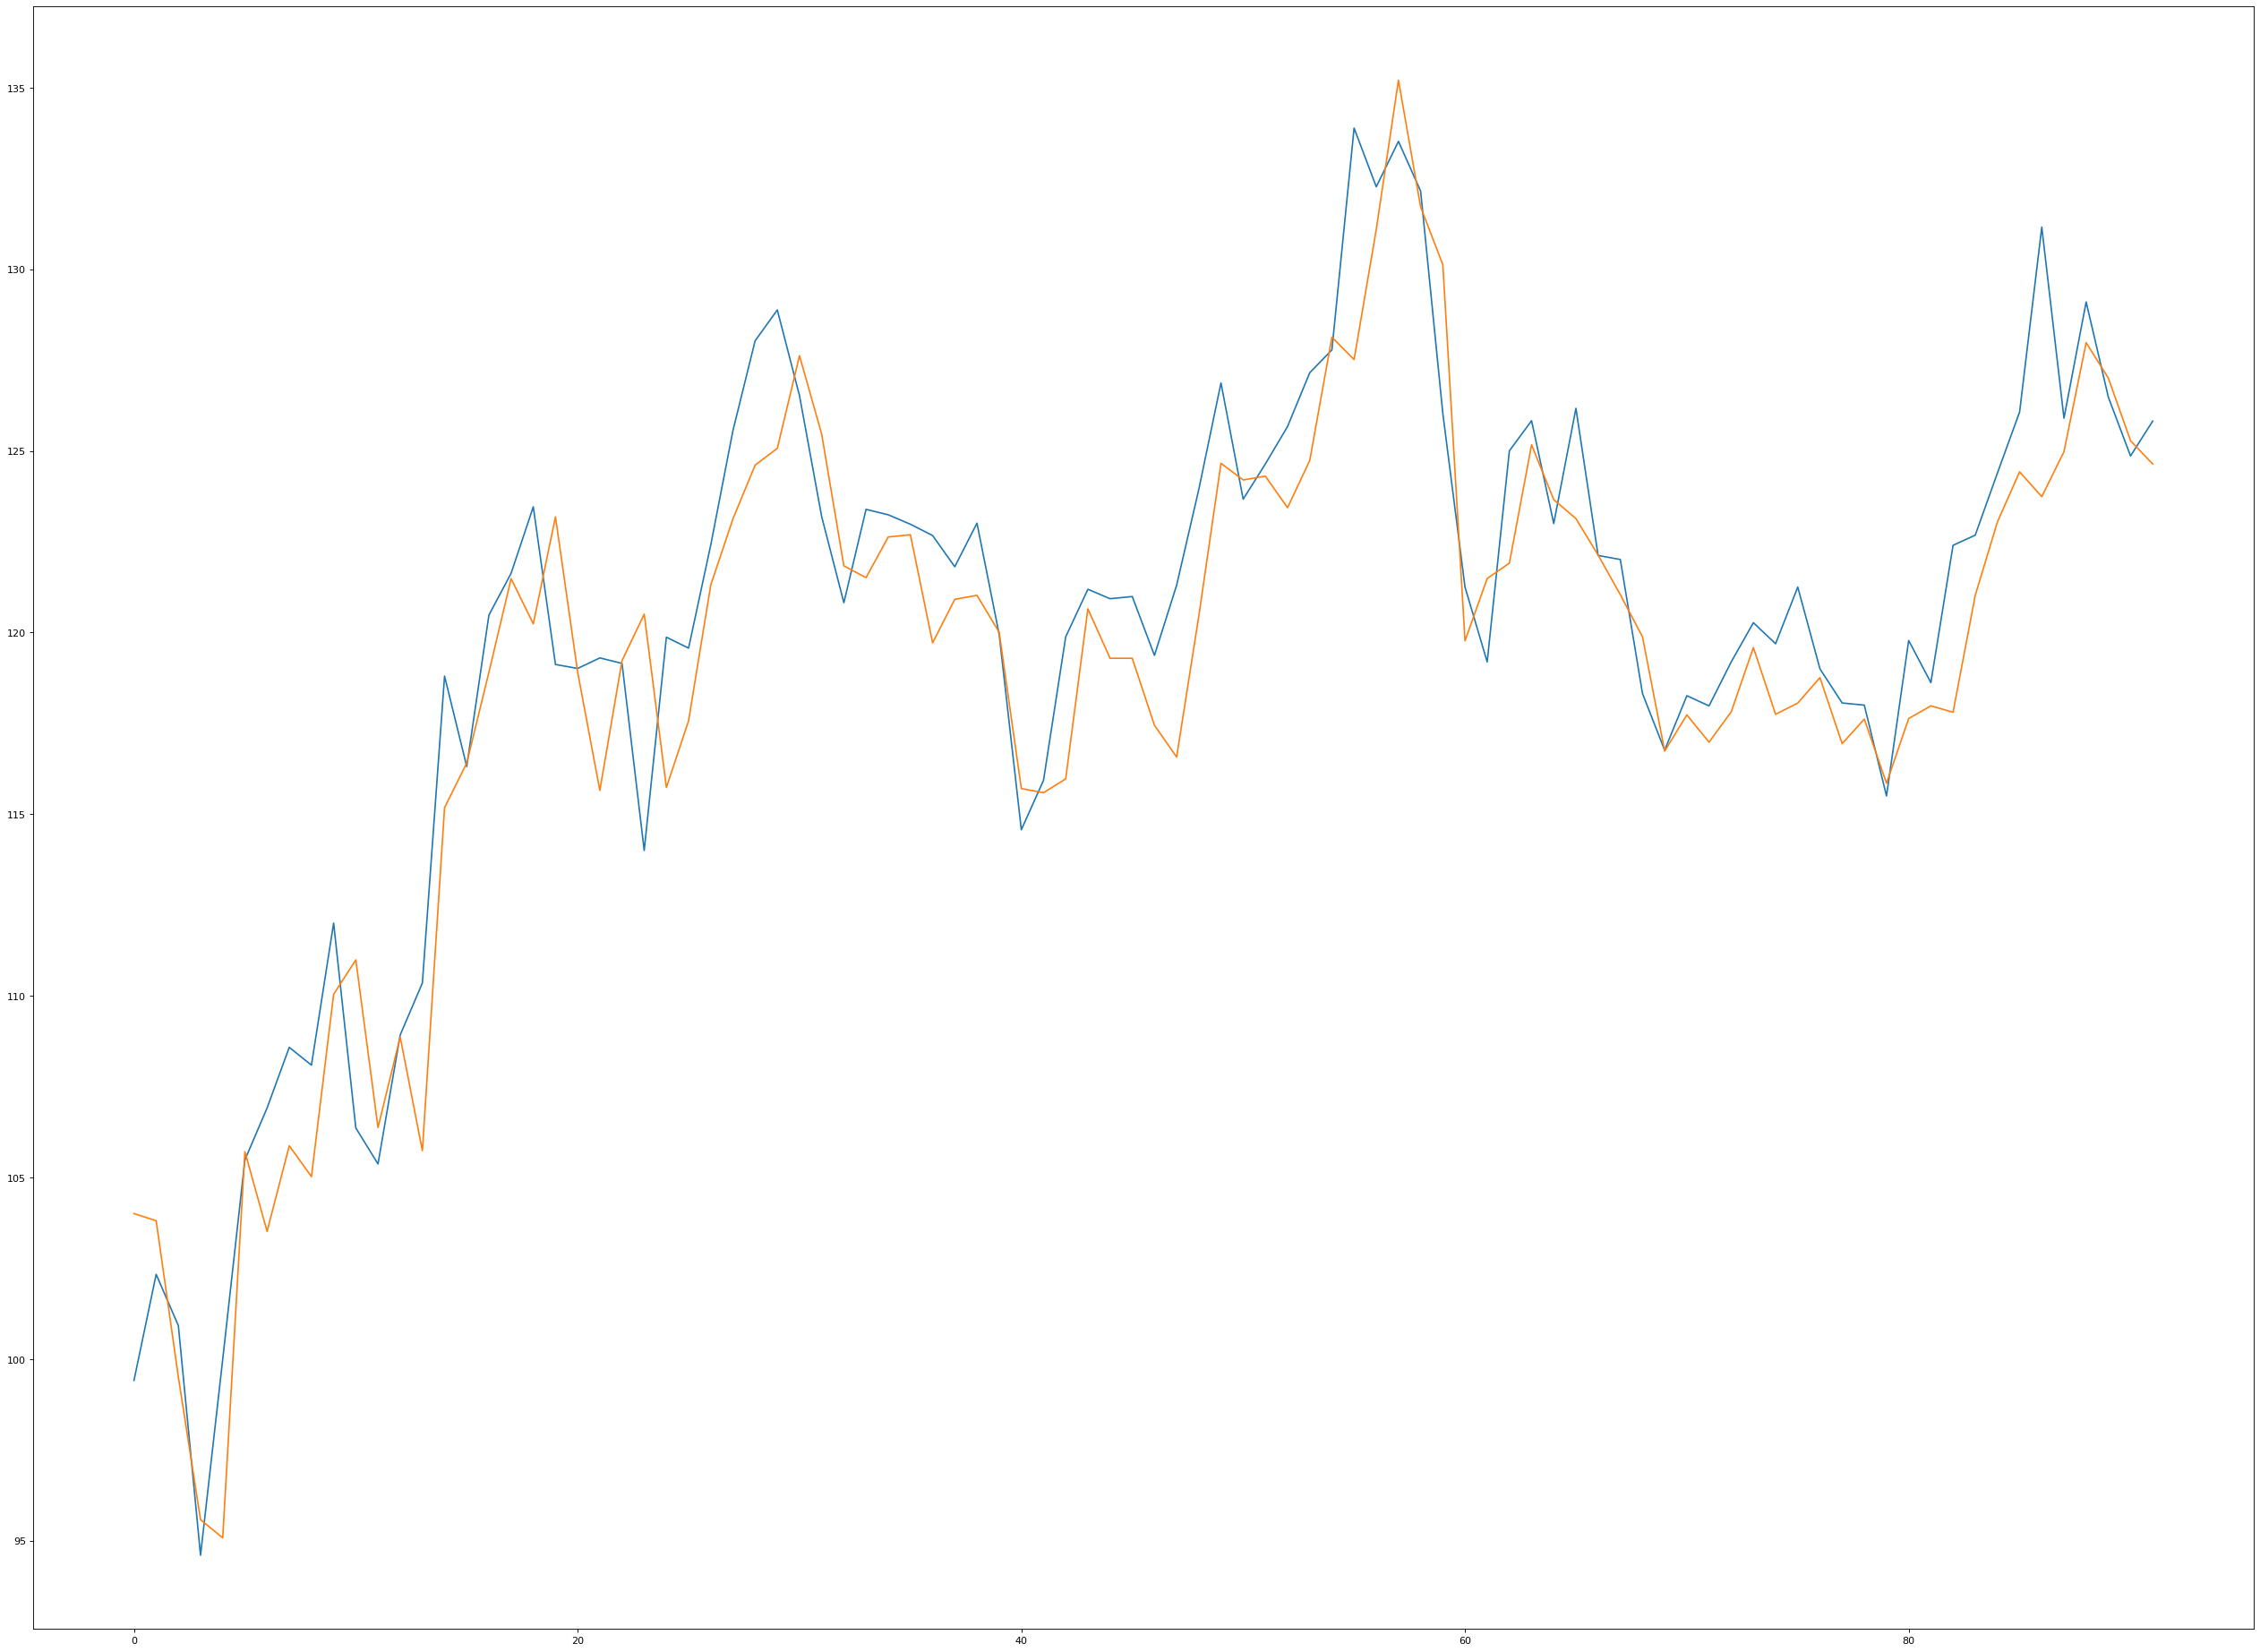

In [30]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:,0])
plt.plot(range(92), predicted_y_test[-92:,0])
plt.show()

##### Predictions over predictions for 30 days on

In [31]:
days = 30

subset = np.array([test_norm[-(backlook+days):-days]])
predicted = np.array(final_model[0].predict(subset))

for i in range(days):
    subset = np.append(subset[:,1:], np.array([[predicted[-1]]]), axis=1)
    predicted = np.append(predicted, final_model[0].predict(subset), axis=0)

In [32]:
predicted = normaliser.inverse_transform(predicted)

Here we can see the model behaviour when it uses its own predictions as input for 30 days

##### Open values

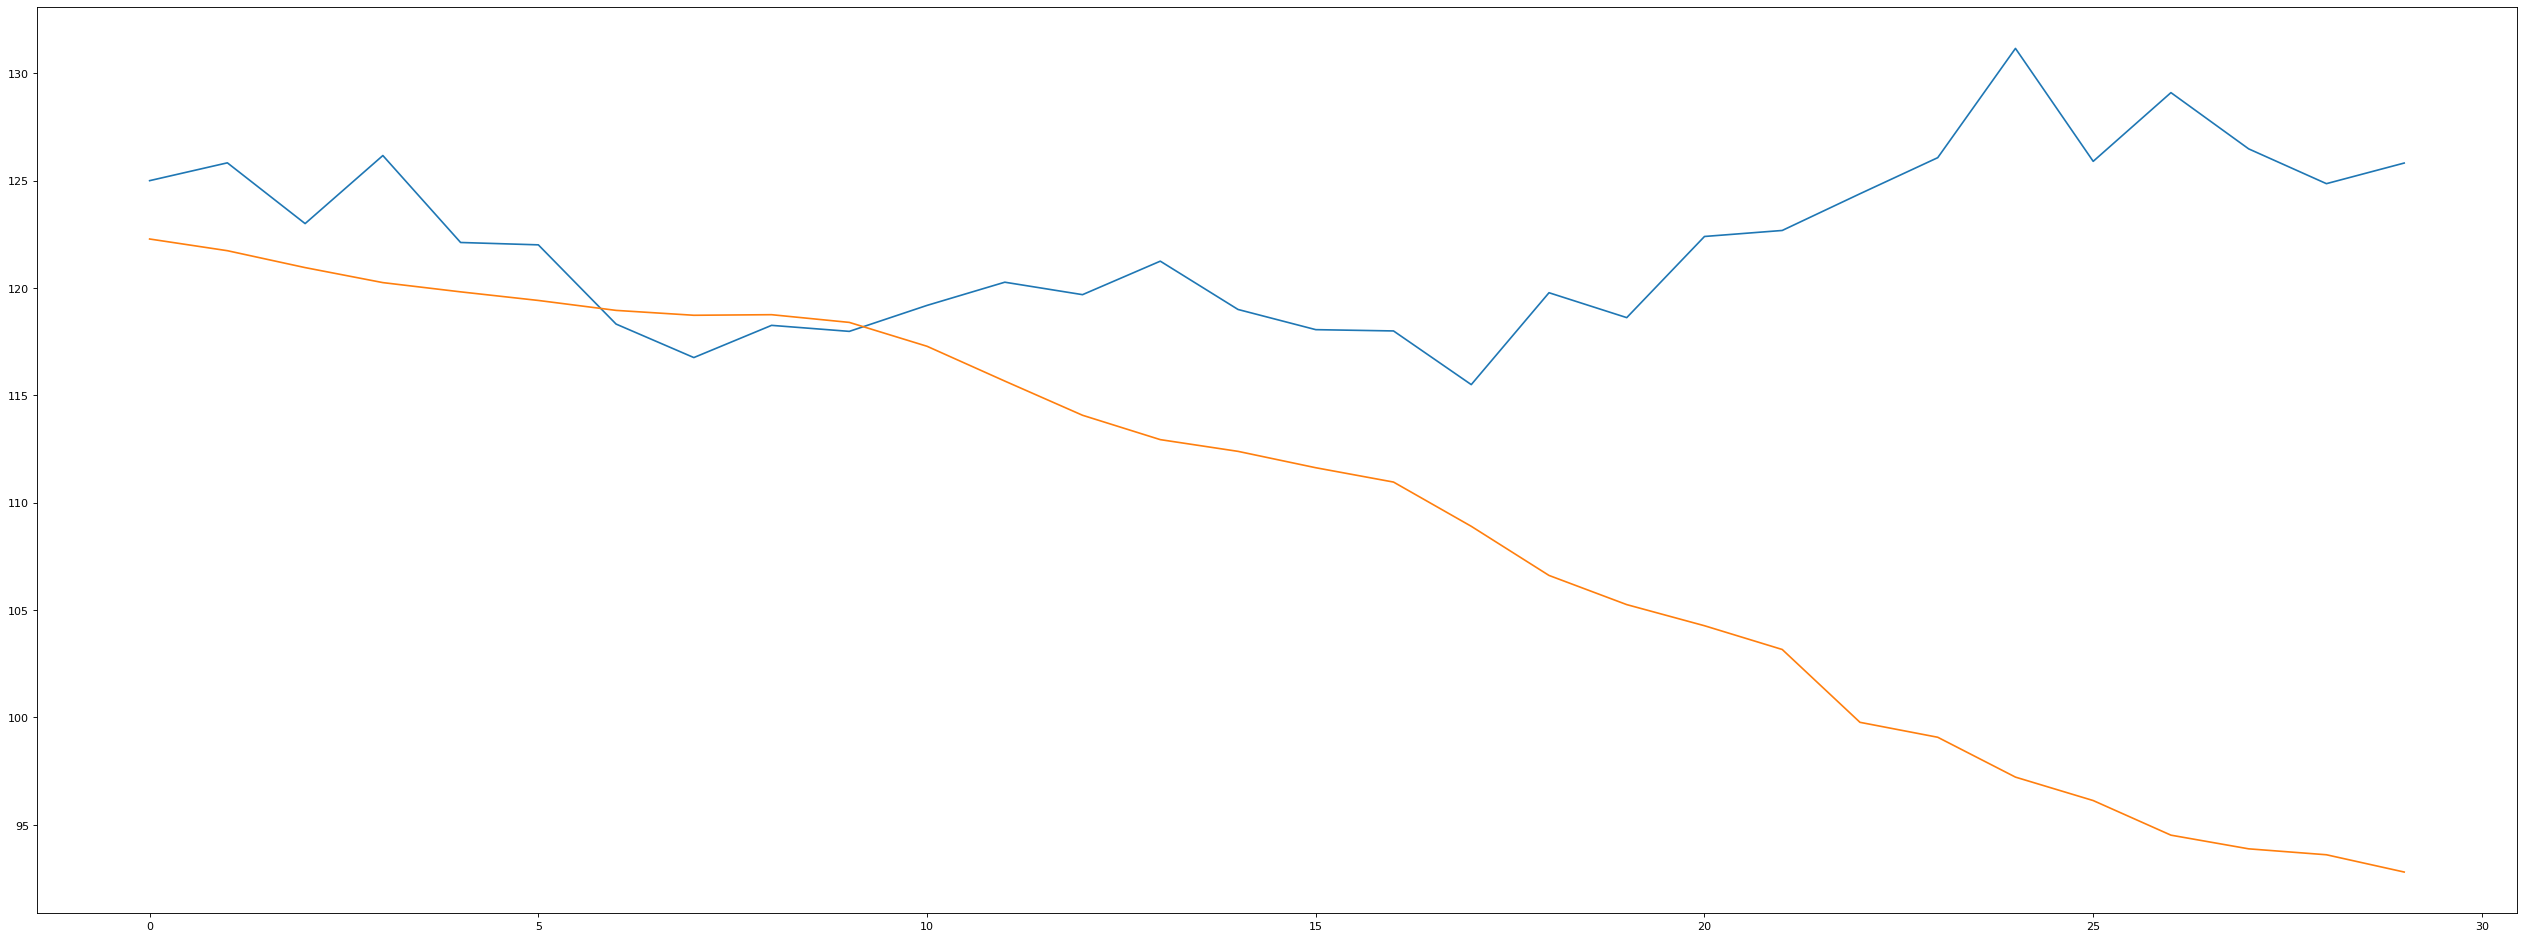

In [33]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,0])
plt.plot(range(days), predicted[-days:,0])
plt.show()

##### High values

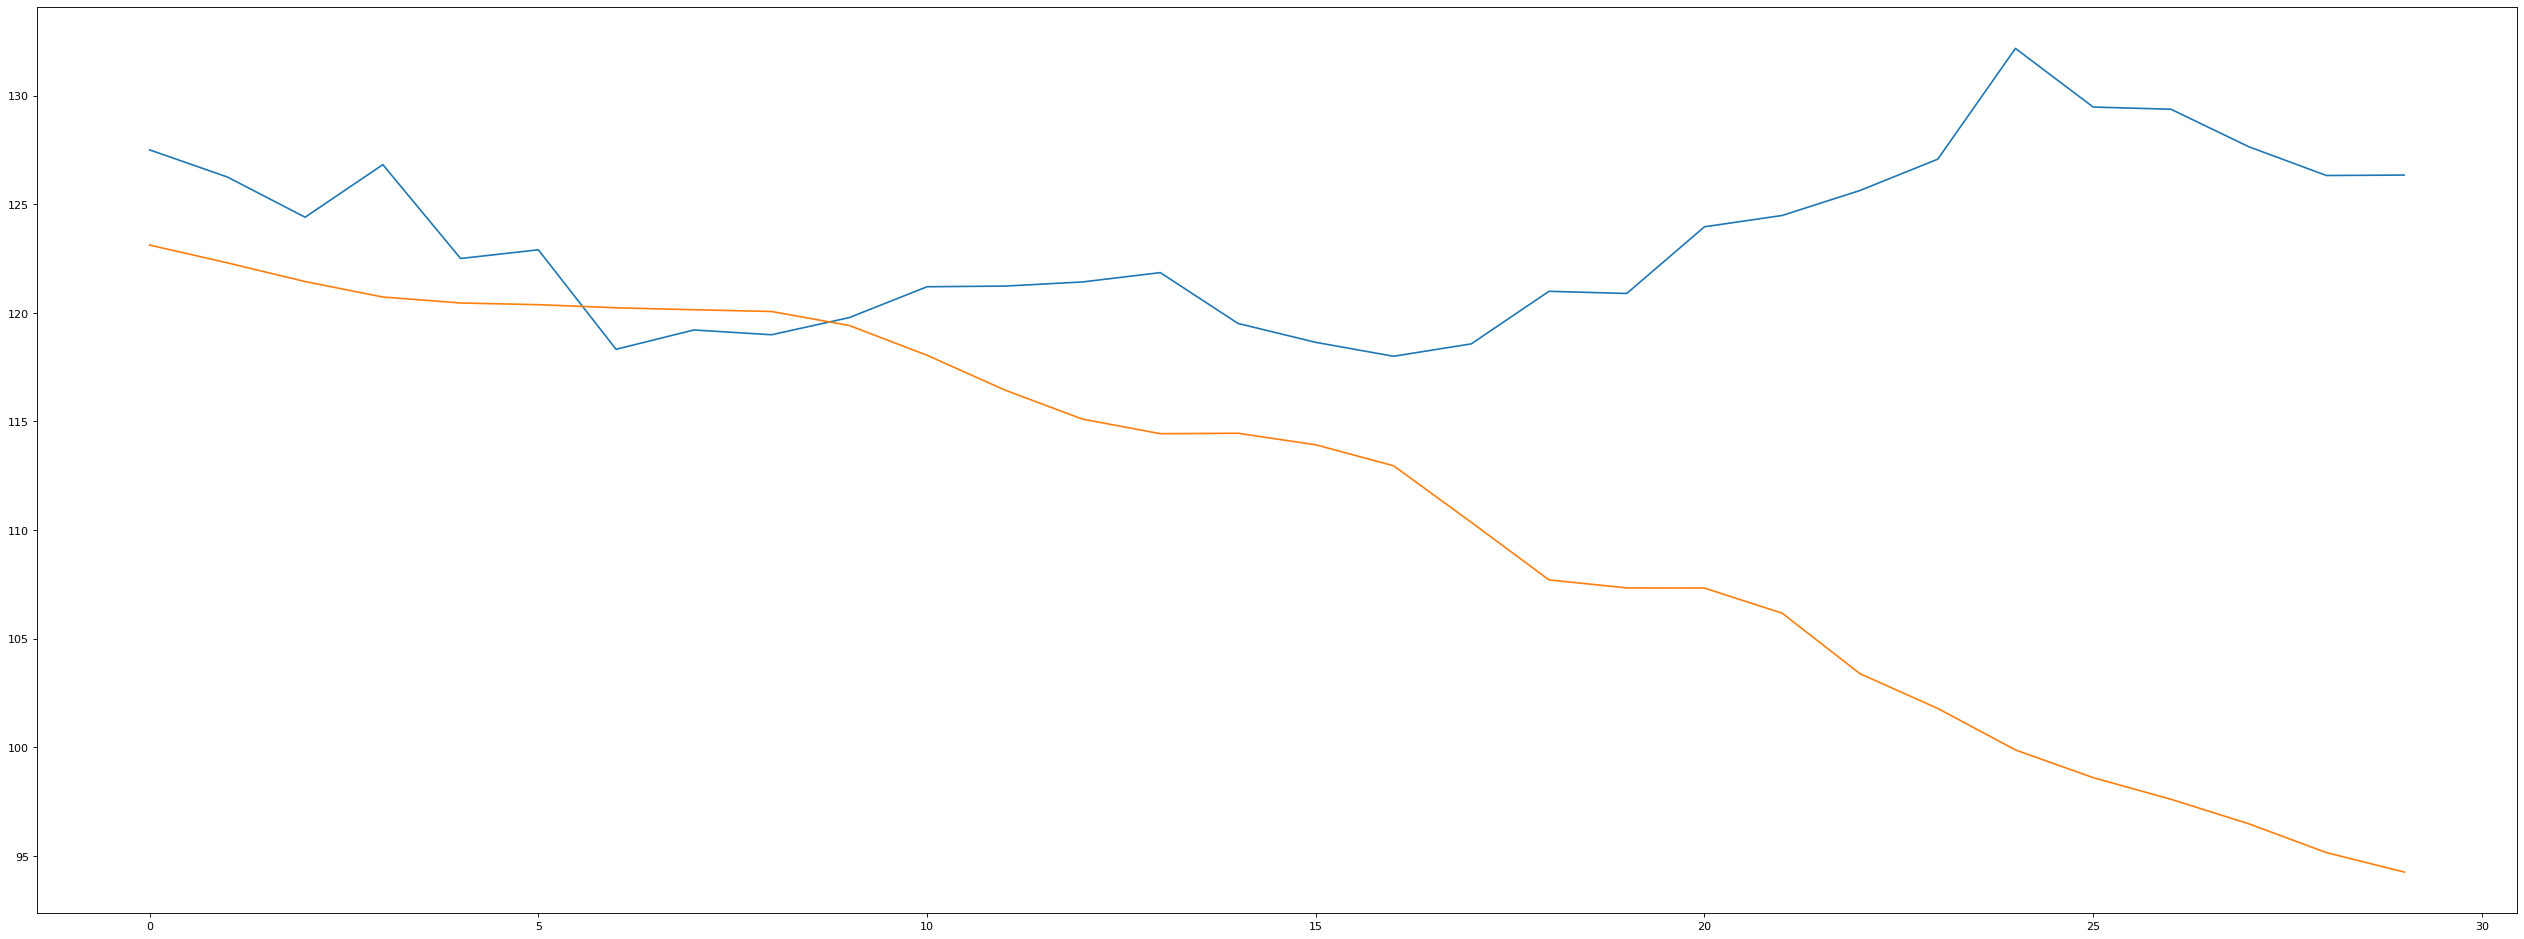

In [36]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,1])
plt.plot(range(days), predicted[-days:,1])
plt.show()

##### Low values

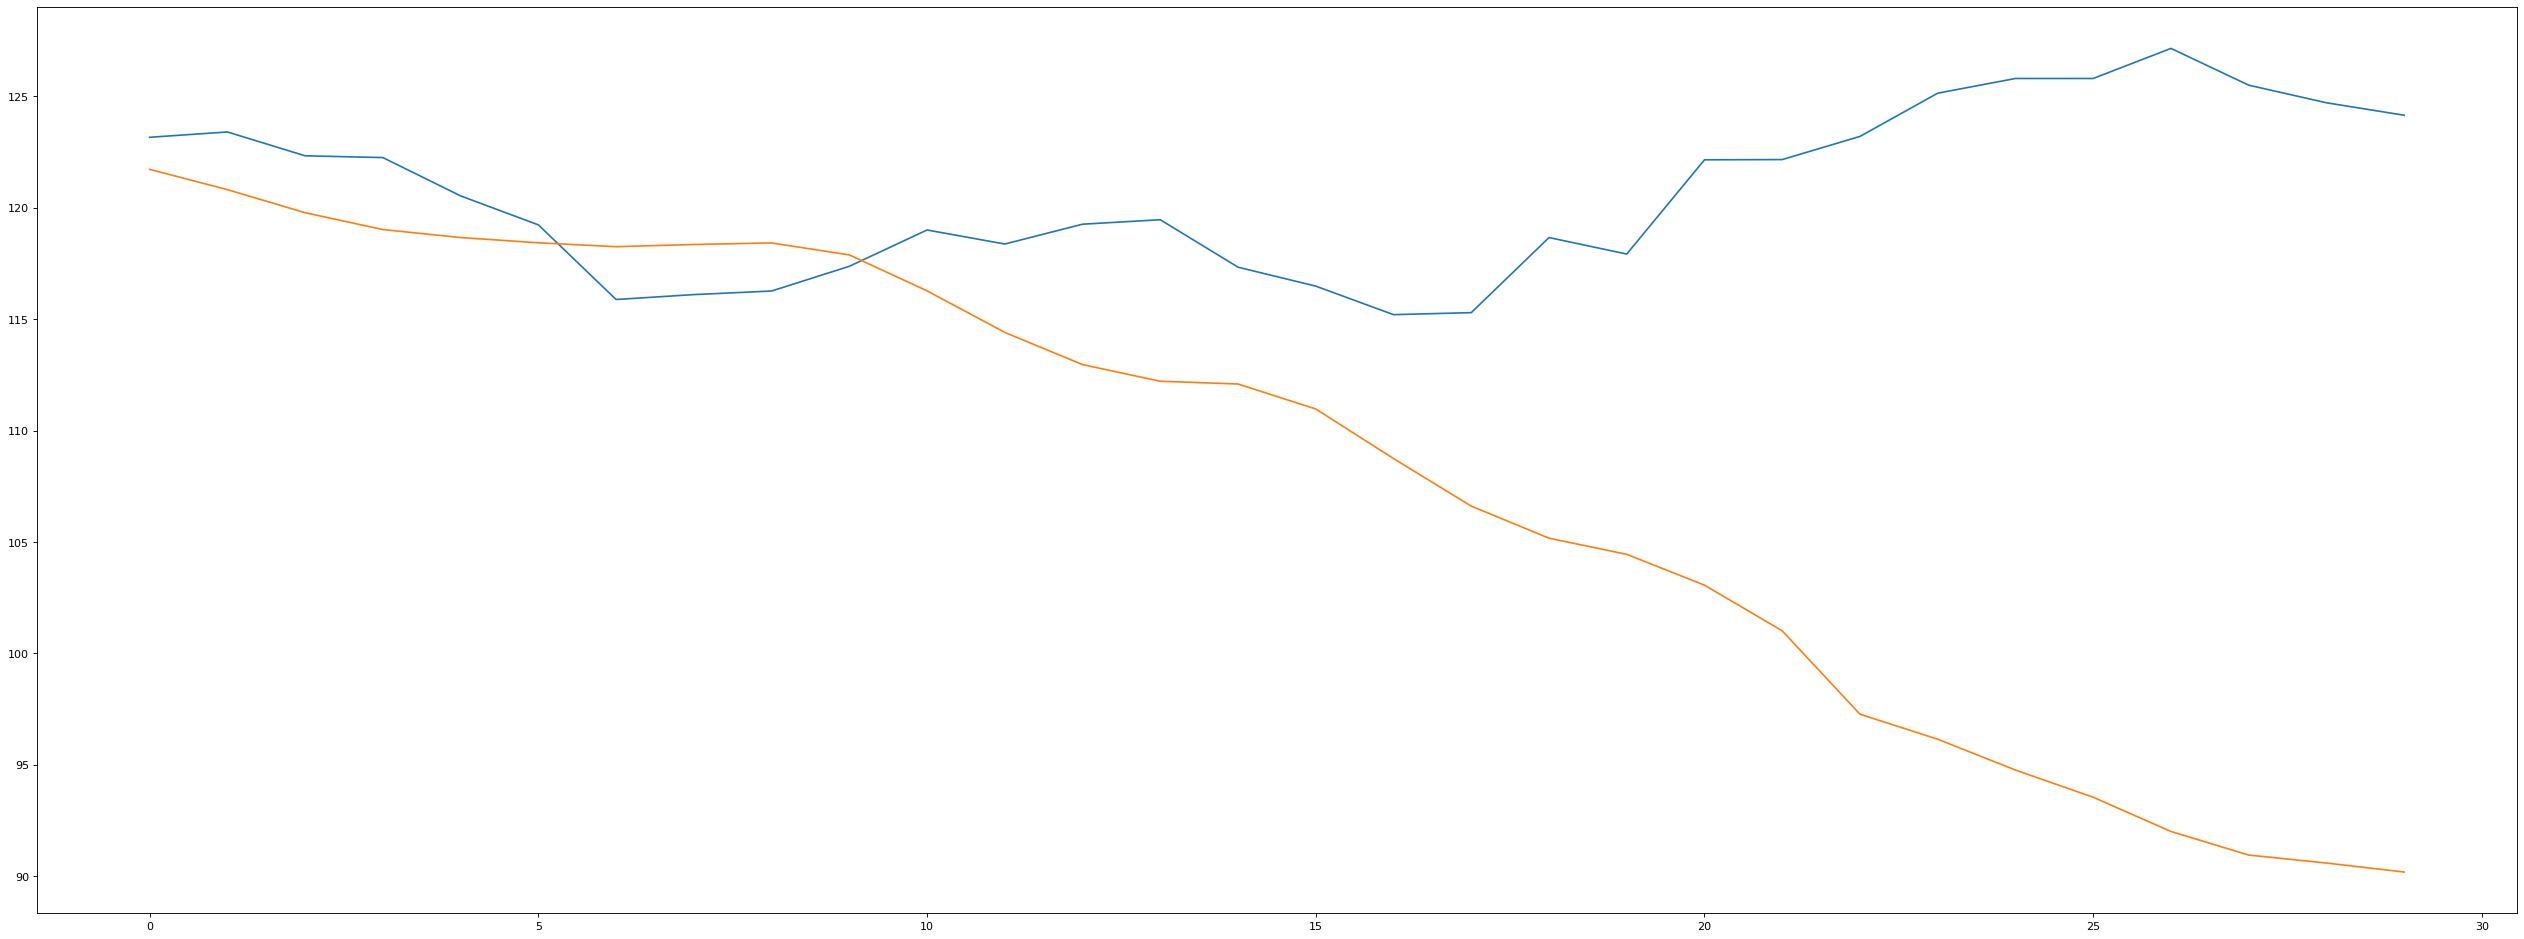

In [37]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,2])
plt.plot(range(days), predicted[-days:,2])
plt.show()

##### Close values

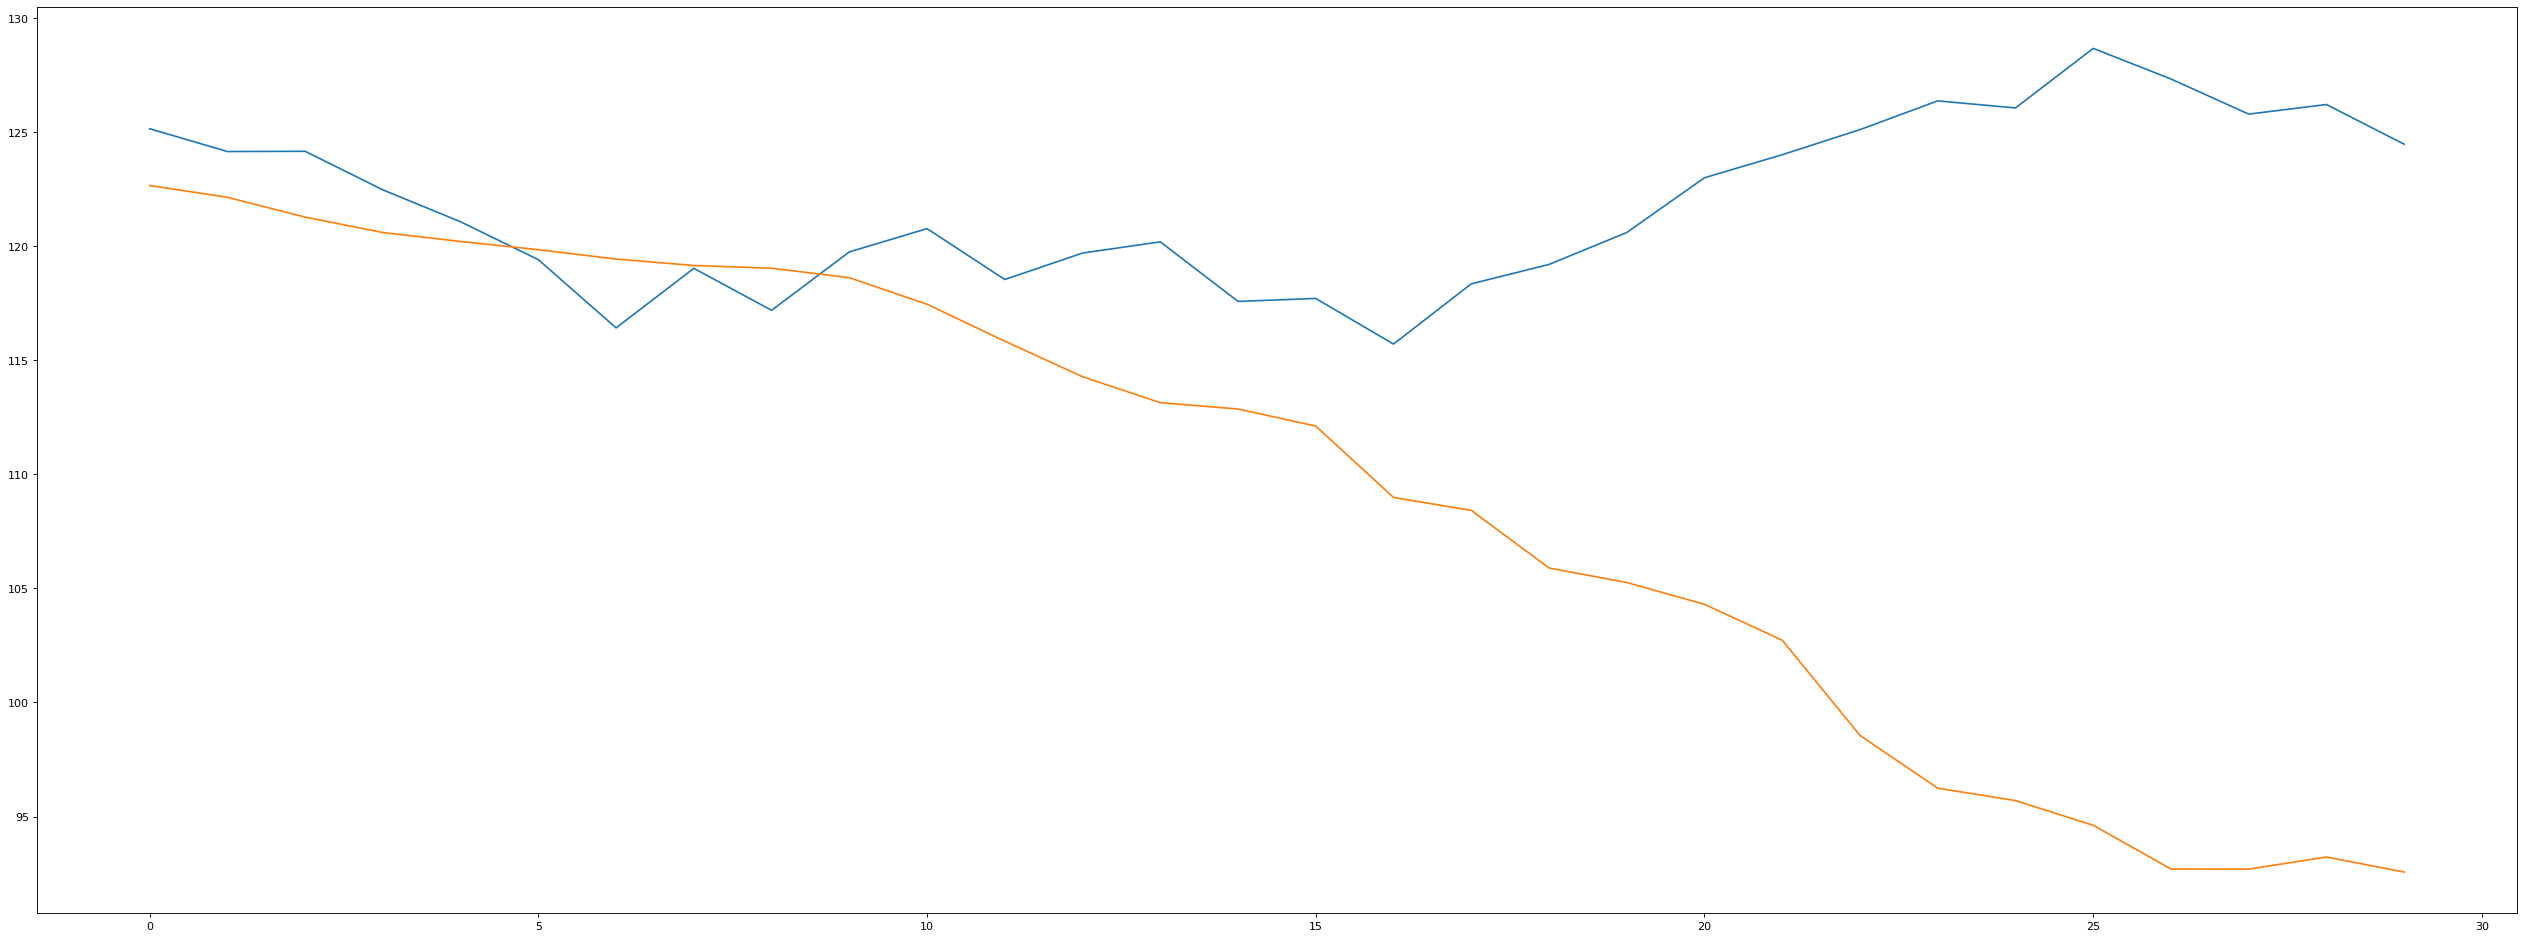

In [38]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,3])
plt.plot(range(days), predicted[-days:,3])
plt.show()

##### Volume values

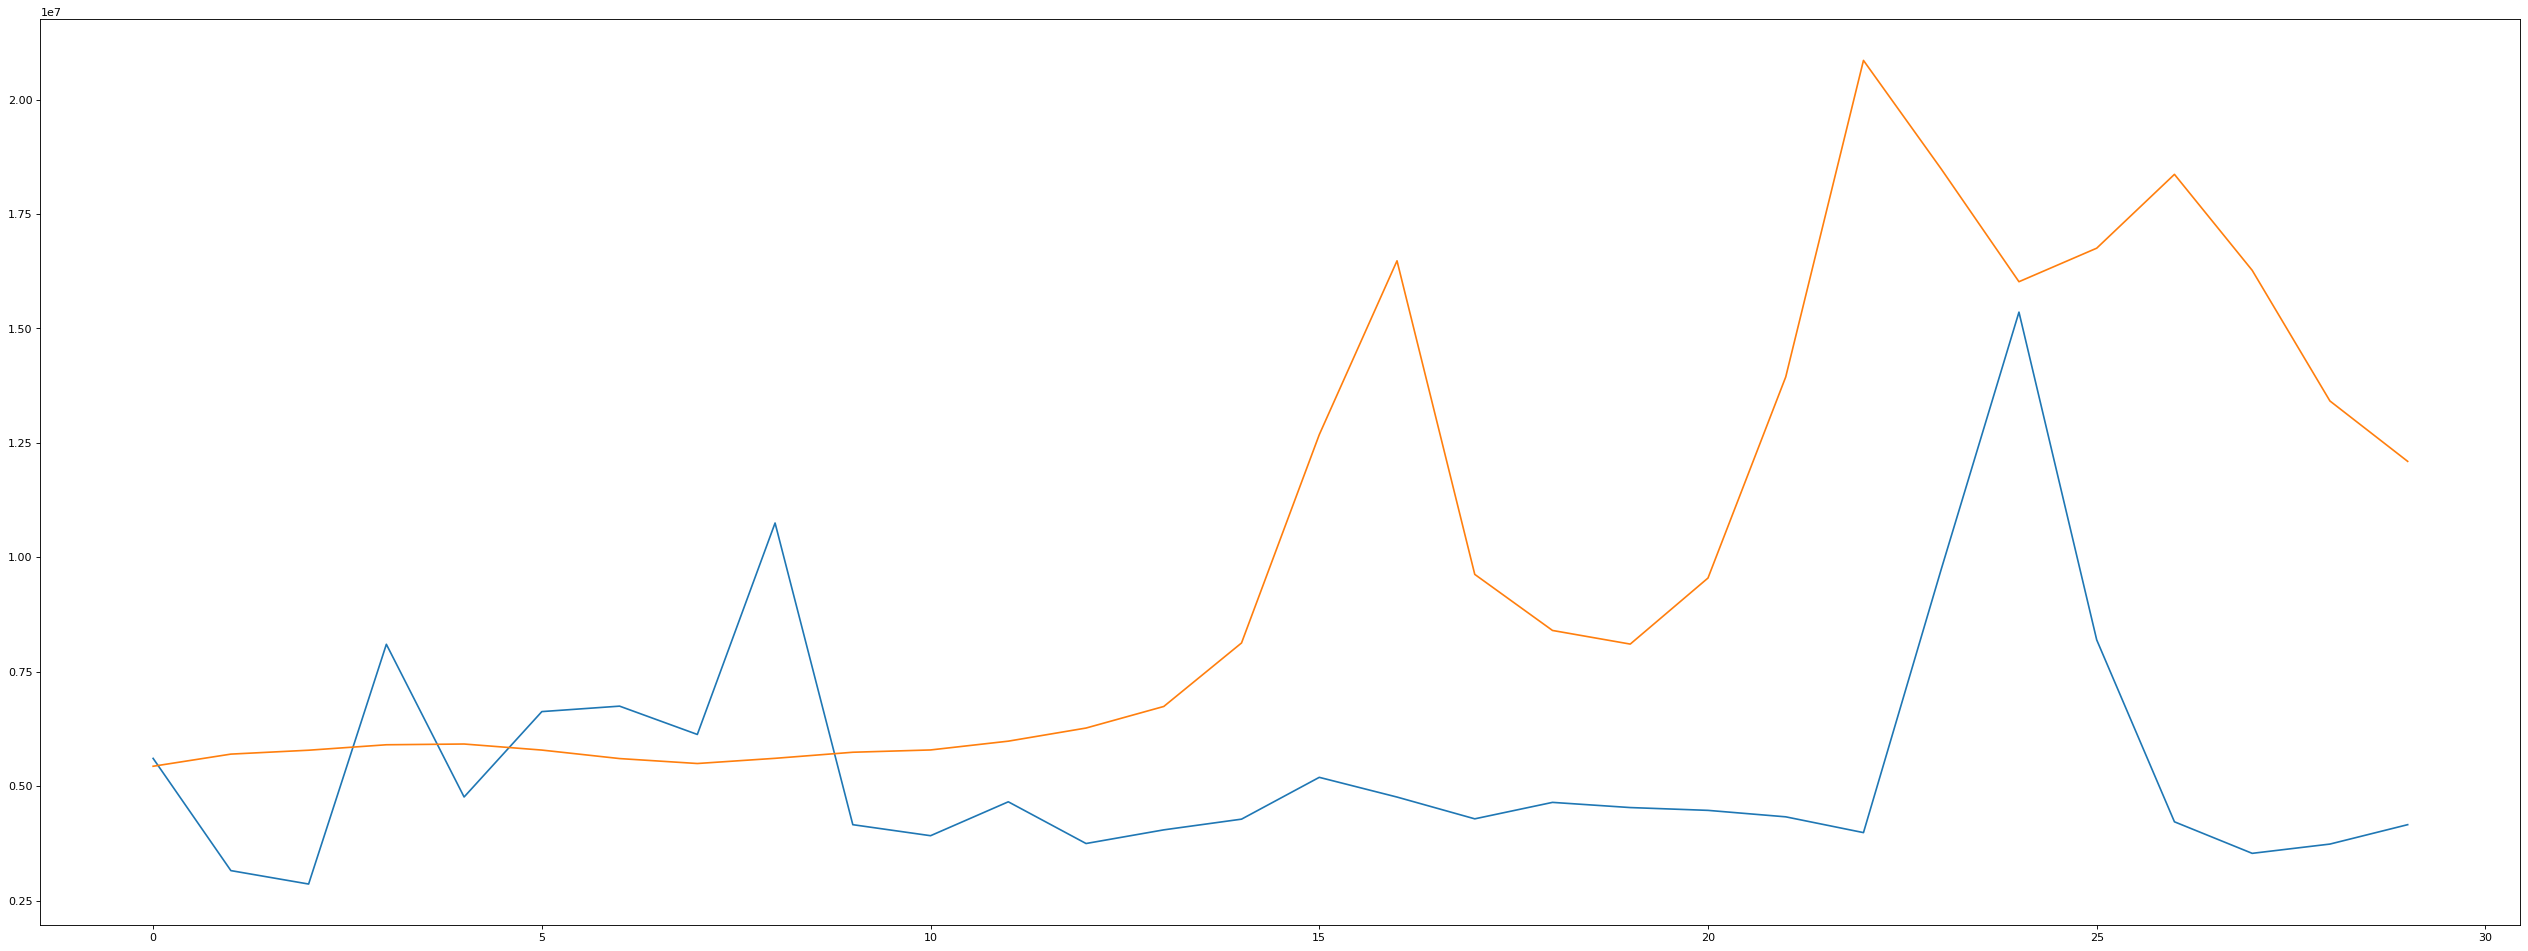

In [39]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,4])
plt.plot(range(days), predicted[-days:,4])
plt.show()

It's not very accurate, but can be used to detect some tendency for the next few days